In [234]:
# imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
%matplotlib inline

In [43]:
# perform camera calibration
images = glob.glob('camera_cal/calibration*.jpg')
object_pts = []
image_pts = []
nx = 9
ny = 6
objpts = np.zeros((ny*nx,3),np.float32)
objpts[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
for image in images:
    gray = cv2.cvtColor(plt.imread(image),cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)
    if ret == True:
        image_pts.append(corners)
        object_pts.append(objpts)
any = plt.imread(images[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_pts, image_pts, (nx,ny), None, None)

In [44]:
# undistort image
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

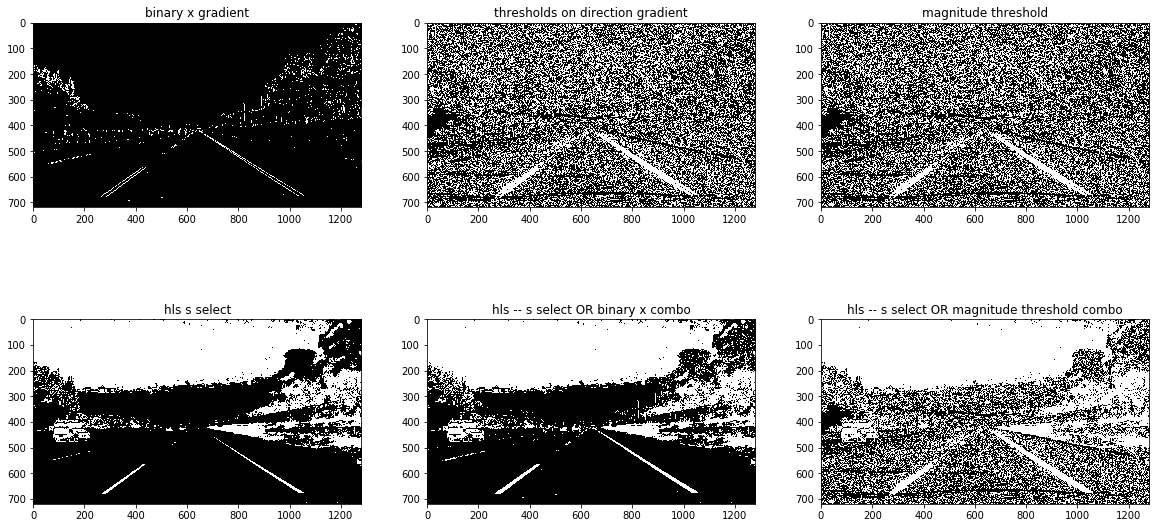

In [151]:
# Use color transforms, gradients, etc., to create a thresholded binary image. 
def sobel(img, direction, ksize): # grayscale image
    if direction == 'x':
        sobel_x = cv2.Sobel(img,cv2.CV_64F,1,0,ksize)
        return sobel_x
    elif direction == 'y':
        sobel_y = cv2.Sobel(img,cv2.CV_64F,0,1,ksize)
        return sobel_y

def sobel_binary(img,direction,ksize,min_thres,max_thres):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobel_x = sobel(gray,direction,ksize)
    sobel_x_abs = np.absolute(sobel_x)
    sobel_x_scale = 255*(sobel_x_abs/np.max(sobel_x_abs))
    binary_x = np.zeros_like(sobel_x_scale)
    binary_x[(sobel_x_scale >= min_thres) & (sobel_x_scale <= max_thres)]=1
    return binary_x

def dir_threshold(img,ksize=15,thres=(0,np.pi/2)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=ksize)
    sobel_y = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=ksize)
    sobel_x_abs = np.absolute(sobel_x)
    sobel_y_abs = np.absolute(sobel_y)
    arctan = np.arctan2(sobel_y_abs,sobel_x_abs)
    binary_arctan = np.zeros_like(arctan)
    binary_arctan[(arctan >= thres[0]) & (arctan <= thres[1])]=1
    return binary_arctan

def mag_thresh(img,ksize=3,thresh=(0,255)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=ksize)
    sobel_y = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=ksize)
    sobel = np.zeros_like(sobel_x)
    for i in range(len(sobel)):
        sobel[i] = np.sqrt(np.power(sobel_x[i],2)+np.power(sobel_y[i],2))
    sobel_scale = np.int8(255*sobel/np.max(sobel))
    binary = np.zeros_like(sobel_scale)
    binary[(sobel_scale >= thresh[0]) & (sobel_scale <= thresh[1])]=1
    return binary

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    hls_s = hls[:,:,2]
    binary_output = np.zeros_like(hls_s)
    binary_output[(hls_s>thresh[0]) & (hls_s<=thresh[1])]=1
    return binary_output

img = mpimg.imread('test_images/straight_lines2.jpg')
binary_x = sobel_binary(img,'x',5,30,200)
direction_thres = dir_threshold(img,15,(0.7,1.3))
magnitude_thres = mag_thresh(img,3,(90,200))
hls_s = hls_select(img,thresh=(90,255))

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20,10))
ax1.set_title('binary x gradient')
ax1.imshow(binary_x,cmap='gray')

ax2.set_title('thresholds on direction gradient')
ax2.imshow(direction_thres,cmap='gray')

ax3.set_title('magnitude threshold')
ax3.imshow(direction_thres,cmap='gray')

ax4.set_title('hls s select')
ax4.imshow(hls_s,cmap='gray')

combined_binary = np.zeros_like(binary_x)
combined_binary[(binary_x == 1) | (hls_s == 1)] = 1

ax5.set_title('hls -- s select OR binary x combo')
ax5.imshow(combined_binary,cmap='gray')

combined_binary_1 = np.zeros_like(binary_x)
combined_binary_1[(direction_thres == 1) | (hls_s == 1)] = 1

ax6.set_title('hls -- s select OR magnitude threshold combo')
ax6.imshow(combined_binary_1,cmap='gray')

# from all the above selecting combination of HLS - s channel and sobel in x direction 
# with thresholds applied

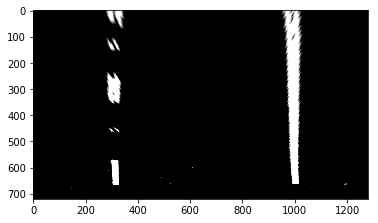

In [226]:
# apply perspective transformationm  to above binary image
def perspective_transform(gray):
    src = np.float32(
                    [
                        [447,550],
                        [300,650],
                        [874,550],
                        [1050,650]
                    ]
                    )
    dst = np.float32(
                    [
                        [300,550],
                        [300,650],
                        [1050,550],
                        [1050,650]
                    ]
                    )
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(gray, M, (gray.shape[1],gray.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

def inverse_perspective_transform(img):
    src = np.float32(
                    [
                        [447,550],
                        [300,650],
                        [874,550],
                        [1050,650]
                    ]
                    )
    dst = np.float32(
                    [
                        [300,550],
                        [300,650],
                        [1050,550],
                        [1050,650]
                    ]
                    )
    Minv = cv2.getPerspectiveTransform(dst, src)
    wraped_inv = cv2.warpPerspective(img, Minv, (img.shape[1],img.shape[0]))
    return wraped_inv
wraped = perspective_transform(combined_binary)
plt.imshow(wraped,cmap='gray')

In [200]:
# detect lane pixels
def find_lane_pixels(wraped):
    converted_img = wraped/255
    bottom_half = converted_img[int(converted_img.shape[0]/2):,:]
    histogram = np.sum(bottom_half,axis=0)
    plt.plot(histogram)
    midpoint = np.int(histogram.shape[0]//2)
    left_x_base = np.argmax(histogram[:midpoint])
    right_x_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    margin = 100
    minpix = 50
    window_height = np.int(converted_img.shape[0]//nwindows)
    nonzero = converted_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_x_current = leftx_base
    right_x_current = rightx_base
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        win_y_low = converted_img.shape[0]-(window+1)*window_height
        win_y_high = converted_img.shape[0]-window*window_height
        win_x_left_low = left_x_current-margin
        win_x_left_high = left_x_current+margin
        win_x_right_low = right_x_current-margin
        win_x_right_high = right_x_current+margin
        included_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_x_left_low) &  (nonzerox < win_x_left_high)).nonzero()[0]
        included_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_x_right_low) &  (nonzerox < win_x_right_high)).nonzero()[0]
        left_lane_inds.append(included_left_inds)
        right_lane_inds.append(included_right_inds)
        if len(included_left_inds) > minpix:
            left_x_current=np.int(np.mean(nonzerox[included_left_inds]))
        if len(included_right_inds) > minpix:
            right_x_current=np.int(np.mean(nonzerox[included_right_inds]))
            
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
        
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx,lefty,rightx,righty


320
993


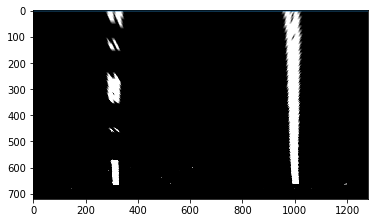

In [228]:
# fit the lane boundary
def fit_polynomial(binary_wraped):
    leftx, lefty, rightx, righty = find_lane_pixels(binary_wraped)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_wraped.shape[0]-1, binary_wraped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return binary_wraped,ploty,left_fit,right_fit

out_img,ploty_out,left_fit_out,right_fit_out = fit_polynomial(wraped)
plt.imshow(wraped,cmap='gray')

In [229]:
# Determine the curvature of the lane and vehicle position with respect to center
def curvature_pixels(ploty,left_fit,right_fit):
    ym_per_pix = 30/720
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad

print(curvature_pixels(ploty_out,left_fit_out,right_fit_out))

(6376.665927912564, 44626.82973851928)


265
992
(720, 1280, 3)
(720, 1280, 3)


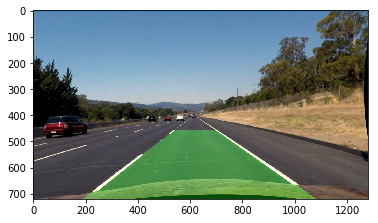

In [236]:
# Warp the detected lane boundaries back onto the original image
def pipeline(img):
    #remove any distortion
    undistorted_image = undistort(img)
    # get binary image with gradient in x direction in specified threshold range
    binary_x = sobel_binary(undistorted_image,'x',5,30,200)
    # get S channel in HLS color space and appy thresholds
    hls_s = hls_select(undistorted_image,thresh=(90,255))
    # combine the above two to get robust mechanism to detect lanes
    combined_binary = np.zeros_like(binary_x)
    combined_binary[(binary_x == 1) | (hls_s == 1)] = 1
    # apply perspective transform
    img_wraped = perspective_transform(combined_binary)
    #find lanes and fit polynomial
    binary_wraped,ploty,left_fit,right_fit = fit_polynomial(img_wraped)
    warp_zero = np.zeros_like(img_wraped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    newWrap = inverse_perspective_transform(color_warp)
    result = cv2.addWeighted(undistorted_image, 1, newWrap, 0.3, 0)
    return result
    
test_img = mpimg.imread('test_images/straight_lines2.jpg')
plt.imshow(pipeline(test_img))

257
1073
(720, 1280, 3)
(720, 1280, 3)
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

257
1073
(720, 1280, 3)
(720, 1280, 3)
262
1053
(720, 1280, 3)
(720, 1280, 3)

  0%|          | 2/1261 [00:00<01:59, 10.56it/s]


251
1052


  0%|          | 3/1261 [00:00<02:02, 10.25it/s]

(720, 1280, 3)
(720, 1280, 3)
266
1052
(720, 1280, 3)
(720, 1280, 3)


  0%|          | 5/1261 [00:00<02:00, 10.42it/s]

309
1056
(720, 1280, 3)
(720, 1280, 3)
255
1065
(720, 1280, 3)
(720, 1280, 3)
250
1048
(720, 1280, 3)
(720, 1280, 3)


  1%|          | 7/1261 [00:00<01:57, 10.69it/s]

268
1054


  1%|          | 8/1261 [00:00<02:11,  9.55it/s]

(720, 1280, 3)
(720, 1280, 3)


  1%|          | 9/1261 [00:00<02:16,  9.19it/s]

262
1046
(720, 1280, 3)
(720, 1280, 3)
278
1050


  1%|          | 10/1261 [00:01<02:15,  9.26it/s]

(720, 1280, 3)
(720, 1280, 3)


  1%|          | 11/1261 [00:01<02:13,  9.39it/s]

305
1055
(720, 1280, 3)
(720, 1280, 3)
306
1061


  1%|          | 12/1261 [00:01<02:11,  9.46it/s]

(720, 1280, 3)
(720, 1280, 3)
250
1064
(720, 1280, 3)
(720, 1280, 3)
233
1065
(720, 1280, 3)
(720, 1280, 3)


  1%|          | 14/1261 [00:01<02:08,  9.72it/s]

243
1060


  1%|          | 15/1261 [00:01<02:07,  9.74it/s]

(720, 1280, 3)
(720, 1280, 3)
262
1057
(720, 1280, 3)
(720, 1280, 3)
275
1035
(720, 1280, 3)
(720, 1280, 3)


  1%|▏         | 17/1261 [00:01<02:06,  9.87it/s]

300
1037
(720, 1280, 3)
(720, 1280, 3)
244
1039


  2%|▏         | 19/1261 [00:01<02:03, 10.06it/s]

(720, 1280, 3)
(720, 1280, 3)
231
1034


  2%|▏         | 21/1261 [00:02<01:59, 10.37it/s]

(720, 1280, 3)
(720, 1280, 3)
233
1024
(720, 1280, 3)
(720, 1280, 3)
253
1037
(720, 1280, 3)
(720, 1280, 3)


  2%|▏         | 23/1261 [00:02<01:56, 10.66it/s]

220
1041
(720, 1280, 3)
(720, 1280, 3)
221
1040
(720, 1280, 3)
(720, 1280, 3)
219
1035


  2%|▏         | 25/1261 [00:02<01:54, 10.77it/s]

(720, 1280, 3)
(720, 1280, 3)
214
1039
(720, 1280, 3)
(720, 1280, 3)
219
1059


  2%|▏         | 27/1261 [00:02<01:53, 10.86it/s]

(720, 1280, 3)
(720, 1280, 3)
235
1048
(720, 1280, 3)
(720, 1280, 3)
250
1048
(720, 1280, 3)
(720, 1280, 3)


  2%|▏         | 29/1261 [00:02<01:55, 10.66it/s]

223
1046


  2%|▏         | 31/1261 [00:02<01:51, 11.01it/s]

(720, 1280, 3)
(720, 1280, 3)
233
1035
(720, 1280, 3)
(720, 1280, 3)
264
1032
(720, 1280, 3)
(720, 1280, 3)


  3%|▎         | 33/1261 [00:03<01:53, 10.86it/s]

247
1033
(720, 1280, 3)
(720, 1280, 3)
265
1034
(720, 1280, 3)
(720, 1280, 3)
244
1043


  3%|▎         | 35/1261 [00:03<01:55, 10.66it/s]

(720, 1280, 3)
(720, 1280, 3)
248
1041
(720, 1280, 3)
(720, 1280, 3)
244
1037


  3%|▎         | 37/1261 [00:03<01:54, 10.72it/s]

(720, 1280, 3)
(720, 1280, 3)
258
1037
(720, 1280, 3)
(720, 1280, 3)
244
1042


  3%|▎         | 39/1261 [00:03<01:58, 10.29it/s]

(720, 1280, 3)
(720, 1280, 3)
238
1046
(720, 1280, 3)
(720, 1280, 3)
247
1049


  3%|▎         | 41/1261 [00:03<01:55, 10.54it/s]

(720, 1280, 3)
(720, 1280, 3)
265
1031
(720, 1280, 3)
(720, 1280, 3)
265
1038


  3%|▎         | 43/1261 [00:04<01:58, 10.25it/s]

(720, 1280, 3)
(720, 1280, 3)
263
1051
(720, 1280, 3)
(720, 1280, 3)
236
1053


  4%|▎         | 45/1261 [00:04<02:01, 10.04it/s]

(720, 1280, 3)
(720, 1280, 3)
236
1029
(720, 1280, 3)
(720, 1280, 3)
254
1038
(720, 1280, 3)
(720, 1280, 3)


  4%|▎         | 47/1261 [00:04<01:59, 10.14it/s]

268
1039
(720, 1280, 3)
(720, 1280, 3)
283
1037


  4%|▍         | 49/1261 [00:04<02:01,  9.98it/s]

(720, 1280, 3)
(720, 1280, 3)
304
1041
(720, 1280, 3)
(720, 1280, 3)
315
1029
(720, 1280, 3)
(720, 1280, 3)


  4%|▍         | 51/1261 [00:04<02:00, 10.07it/s]

230
1050


  4%|▍         | 53/1261 [00:05<01:59, 10.09it/s]

(720, 1280, 3)
(720, 1280, 3)
236
1030
(720, 1280, 3)
(720, 1280, 3)
252
1031


  4%|▍         | 55/1261 [00:05<02:01,  9.93it/s]

(720, 1280, 3)
(720, 1280, 3)
239
1033
(720, 1280, 3)
(720, 1280, 3)
246
1049


  5%|▍         | 57/1261 [00:05<02:08,  9.40it/s]

(720, 1280, 3)
(720, 1280, 3)
219
1050
(720, 1280, 3)
(720, 1280, 3)
219
1038


  5%|▍         | 58/1261 [00:05<02:06,  9.54it/s]

(720, 1280, 3)
(720, 1280, 3)
236
1020
(720, 1280, 3)
(720, 1280, 3)
234
1020


  5%|▍         | 62/1261 [00:06<01:59, 10.05it/s]

(720, 1280, 3)
(720, 1280, 3)
230
1021
(720, 1280, 3)
(720, 1280, 3)
229
1000
(720, 1280, 3)
(720, 1280, 3)


  5%|▌         | 64/1261 [00:06<01:56, 10.29it/s]

221
1020
(720, 1280, 3)
(720, 1280, 3)
220
1021
(720, 1280, 3)
(720, 1280, 3)
227
1029


  5%|▌         | 66/1261 [00:06<01:55, 10.30it/s]

(720, 1280, 3)
(720, 1280, 3)
242
1031
(720, 1280, 3)
(720, 1280, 3)
220
1015


  5%|▌         | 68/1261 [00:06<02:03,  9.66it/s]

(720, 1280, 3)
(720, 1280, 3)
220
1019
(720, 1280, 3)
(720, 1280, 3)
225
1025


  5%|▌         | 69/1261 [00:06<02:04,  9.58it/s]

(720, 1280, 3)
(720, 1280, 3)
222
1035
(720, 1280, 3)
(720, 1280, 3)
239
1004
(720, 1280, 3)
(720, 1280, 3)


  6%|▌         | 72/1261 [00:07<02:07,  9.35it/s]

251
971
(720, 1280, 3)
(720, 1280, 3)
260
979
(720, 1280, 3)
(720, 1280, 3)
271
983


  6%|▌         | 76/1261 [00:07<01:59,  9.88it/s]

(720, 1280, 3)
(720, 1280, 3)
283
1013
(720, 1280, 3)
(720, 1280, 3)
218
996
(720, 1280, 3)
(720, 1280, 3)


  6%|▌         | 77/1261 [00:07<02:01,  9.74it/s]

209
1003
(720, 1280, 3)
(720, 1280, 3)
222
1029
(720, 1280, 3)
(720, 1280, 3)
233
1027


  6%|▋         | 80/1261 [00:07<02:03,  9.58it/s]

(720, 1280, 3)
(720, 1280, 3)
198
1019
(720, 1280, 3)
(720, 1280, 3)
197
1027


  7%|▋         | 82/1261 [00:08<01:59,  9.88it/s]

(720, 1280, 3)
(720, 1280, 3)
206
1009
(720, 1280, 3)
(720, 1280, 3)
195
1010
(720, 1280, 3)
(720, 1280, 3)


  7%|▋         | 84/1261 [00:08<01:59,  9.89it/s]

192
1009
(720, 1280, 3)
(720, 1280, 3)
205
1020
(720, 1280, 3)
(720, 1280, 3)


  7%|▋         | 87/1261 [00:08<01:58,  9.89it/s]

208
1020
(720, 1280, 3)
(720, 1280, 3)
209
1016
(720, 1280, 3)
(720, 1280, 3)
202
1008


  7%|▋         | 89/1261 [00:08<02:01,  9.65it/s]

(720, 1280, 3)
(720, 1280, 3)
216
1015
(720, 1280, 3)
(720, 1280, 3)
209
1019


  7%|▋         | 91/1261 [00:09<02:03,  9.45it/s]

(720, 1280, 3)
(720, 1280, 3)
220
1024
(720, 1280, 3)
(720, 1280, 3)
232
1023


  7%|▋         | 92/1261 [00:09<02:02,  9.56it/s]

(720, 1280, 3)
(720, 1280, 3)
219
1013
(720, 1280, 3)
(720, 1280, 3)
228
1020
(720, 1280, 3)
(720, 1280, 3)

  8%|▊         | 96/1261 [00:09<02:01,  9.57it/s]


224
1020
(720, 1280, 3)
(720, 1280, 3)
246
996
(720, 1280, 3)
(720, 1280, 3)
234
997


  8%|▊         | 98/1261 [00:09<01:57,  9.90it/s]

(720, 1280, 3)
(720, 1280, 3)
246
1002
(720, 1280, 3)
(720, 1280, 3)
257
1005


  8%|▊         | 100/1261 [00:09<02:06,  9.21it/s]

(720, 1280, 3)
(720, 1280, 3)
234
1005
(720, 1280, 3)
(720, 1280, 3)
247
997


  8%|▊         | 101/1261 [00:10<02:04,  9.30it/s]

(720, 1280, 3)
(720, 1280, 3)
214
1016
(720, 1280, 3)
(720, 1280, 3)
219
1011
(720, 1280, 3)
(720, 1280, 3)


  8%|▊         | 104/1261 [00:10<02:05,  9.25it/s]

227
1014
(720, 1280, 3)
(720, 1280, 3)
246
1005
(720, 1280, 3)
(720, 1280, 3)


  8%|▊         | 107/1261 [00:10<02:06,  9.16it/s]

215
1025
(720, 1280, 3)
(720, 1280, 3)
221
1013
(720, 1280, 3)
(720, 1280, 3)


  9%|▊         | 108/1261 [00:10<02:13,  8.61it/s]

222
1011
(720, 1280, 3)
(720, 1280, 3)
229
1008
(720, 1280, 3)
(720, 1280, 3)


  9%|▊         | 110/1261 [00:11<02:07,  9.05it/s]

225
1021
(720, 1280, 3)
(720, 1280, 3)
227
1024
(720, 1280, 3)
(720, 1280, 3)
221
1017


  9%|▉         | 112/1261 [00:11<02:04,  9.26it/s]

(720, 1280, 3)
(720, 1280, 3)
237
1015
(720, 1280, 3)
(720, 1280, 3)
239
1039
(720, 1280, 3)
(720, 1280, 3)


  9%|▉         | 116/1261 [00:11<02:07,  8.96it/s]

229
1037
(720, 1280, 3)
(720, 1280, 3)
239
1024
(720, 1280, 3)
(720, 1280, 3)


  9%|▉         | 118/1261 [00:11<02:09,  8.83it/s]

246
1029
(720, 1280, 3)
(720, 1280, 3)
246
1034
(720, 1280, 3)
(720, 1280, 3)


 10%|▉         | 120/1261 [00:12<02:04,  9.13it/s]

241
1035
(720, 1280, 3)
(720, 1280, 3)
239
1020
(720, 1280, 3)
(720, 1280, 3)


 10%|▉         | 122/1261 [00:12<01:58,  9.59it/s]

248
1019
(720, 1280, 3)
(720, 1280, 3)
263
1020
(720, 1280, 3)
(720, 1280, 3)
273
1027


 10%|▉         | 124/1261 [00:12<02:08,  8.87it/s]

(720, 1280, 3)
(720, 1280, 3)
291
1022
(720, 1280, 3)
(720, 1280, 3)


 10%|▉         | 125/1261 [00:12<02:07,  8.89it/s]

304
1022
(720, 1280, 3)
(720, 1280, 3)
241
1016
(720, 1280, 3)
(720, 1280, 3)
239
1042


 10%|█         | 128/1261 [00:12<02:02,  9.22it/s]

(720, 1280, 3)
(720, 1280, 3)
241
1047
(720, 1280, 3)
(720, 1280, 3)
252
1047


 10%|█         | 129/1261 [00:13<02:00,  9.40it/s]

(720, 1280, 3)
(720, 1280, 3)
265
1030
(720, 1280, 3)
(720, 1280, 3)
290
1038
(720, 1280, 3)
(720, 1280, 3)


 10%|█         | 132/1261 [00:13<01:59,  9.48it/s]

307
1042
(720, 1280, 3)
(720, 1280, 3)
243
1046
(720, 1280, 3)
(720, 1280, 3)
260
1021


 11%|█         | 135/1261 [00:13<01:57,  9.62it/s]

(720, 1280, 3)
(720, 1280, 3)
279
1030
(720, 1280, 3)
(720, 1280, 3)
294
1036


 11%|█         | 138/1261 [00:13<01:52,  9.98it/s]

(720, 1280, 3)
(720, 1280, 3)
306
1036
(720, 1280, 3)
(720, 1280, 3)
316
1032
(720, 1280, 3)
(720, 1280, 3)


 11%|█         | 140/1261 [00:14<01:52,  9.98it/s]

235
1047
(720, 1280, 3)
(720, 1280, 3)
241
1058
(720, 1280, 3)
(720, 1280, 3)


 11%|█▏        | 142/1261 [00:14<01:52,  9.96it/s]

255
1060
(720, 1280, 3)
(720, 1280, 3)
268
1060
(720, 1280, 3)
(720, 1280, 3)
247
1045


 11%|█▏        | 144/1261 [00:14<01:52,  9.96it/s]

(720, 1280, 3)
(720, 1280, 3)
250
1052
(720, 1280, 3)
(720, 1280, 3)
237
1034
(720, 1280, 3)
(720, 1280, 3)


 12%|█▏        | 146/1261 [00:14<01:49, 10.22it/s]

254
1036
(720, 1280, 3)
(720, 1280, 3)
270
1038
(720, 1280, 3)
(720, 1280, 3)
285
1033


 12%|█▏        | 150/1261 [00:15<01:48, 10.24it/s]

(720, 1280, 3)
(720, 1280, 3)
301
1033
(720, 1280, 3)
(720, 1280, 3)
269
1033
(720, 1280, 3)
(720, 1280, 3)


 12%|█▏        | 152/1261 [00:15<01:49, 10.13it/s]

318
1023
(720, 1280, 3)
(720, 1280, 3)
234
1027
(720, 1280, 3)
(720, 1280, 3)
246
1027


 12%|█▏        | 154/1261 [00:15<01:49, 10.14it/s]

(720, 1280, 3)
(720, 1280, 3)
246
1031
(720, 1280, 3)
(720, 1280, 3)
240
1032
(720, 1280, 3)
(720, 1280, 3)


 12%|█▏        | 157/1261 [00:15<01:53,  9.71it/s]

229
1046
(720, 1280, 3)
(720, 1280, 3)
228
1047
(720, 1280, 3)
(720, 1280, 3)


 13%|█▎        | 158/1261 [00:15<01:52,  9.77it/s]

242
1028
(720, 1280, 3)
(720, 1280, 3)
245
1025
(720, 1280, 3)
(720, 1280, 3)


 13%|█▎        | 160/1261 [00:16<01:55,  9.57it/s]

251
1027
(720, 1280, 3)
(720, 1280, 3)
237
1037
(720, 1280, 3)
(720, 1280, 3)
222
1031


 13%|█▎        | 164/1261 [00:16<01:46, 10.26it/s]

(720, 1280, 3)
(720, 1280, 3)
244
1029
(720, 1280, 3)
(720, 1280, 3)
226
1040
(720, 1280, 3)
(720, 1280, 3)


 13%|█▎        | 166/1261 [00:16<01:46, 10.25it/s]

224
1038
(720, 1280, 3)
(720, 1280, 3)
231
1040
(720, 1280, 3)
(720, 1280, 3)
232
1043


 13%|█▎        | 168/1261 [00:16<01:49,  9.94it/s]

(720, 1280, 3)
(720, 1280, 3)
224
1030
(720, 1280, 3)
(720, 1280, 3)
246
1032


 14%|█▎        | 171/1261 [00:17<01:48, 10.06it/s]

(720, 1280, 3)
(720, 1280, 3)
216
1045
(720, 1280, 3)
(720, 1280, 3)
220
1020
(720, 1280, 3)
(720, 1280, 3)


 14%|█▎        | 173/1261 [00:17<01:46, 10.23it/s]

212
1015
(720, 1280, 3)
(720, 1280, 3)
254
1018
(720, 1280, 3)
(720, 1280, 3)
226
1013


 14%|█▍        | 175/1261 [00:17<01:42, 10.64it/s]

(720, 1280, 3)
(720, 1280, 3)
208
1012
(720, 1280, 3)
(720, 1280, 3)
205
1003
(720, 1280, 3)
(720, 1280, 3)


 14%|█▍        | 177/1261 [00:17<01:43, 10.44it/s]

217
1030
(720, 1280, 3)
(720, 1280, 3)
229
1014
(720, 1280, 3)
(720, 1280, 3)
244
1018


 14%|█▍        | 179/1261 [00:17<01:45, 10.28it/s]

(720, 1280, 3)
(720, 1280, 3)
202
1025
(720, 1280, 3)
(720, 1280, 3)
203
1039


 15%|█▍        | 183/1261 [00:18<01:42, 10.53it/s]

(720, 1280, 3)
(720, 1280, 3)
205
1029
(720, 1280, 3)
(720, 1280, 3)
208
1026
(720, 1280, 3)
(720, 1280, 3)


 15%|█▍        | 185/1261 [00:18<01:42, 10.49it/s]

222
1027
(720, 1280, 3)
(720, 1280, 3)
216
1028
(720, 1280, 3)
(720, 1280, 3)
231
1019


 15%|█▍        | 187/1261 [00:18<01:40, 10.64it/s]

(720, 1280, 3)
(720, 1280, 3)
239
1020
(720, 1280, 3)
(720, 1280, 3)
259
1010
(720, 1280, 3)
(720, 1280, 3)


 15%|█▍        | 189/1261 [00:18<01:42, 10.49it/s]

272
1015
(720, 1280, 3)
(720, 1280, 3)
280
1031
(720, 1280, 3)
(720, 1280, 3)


 15%|█▌        | 191/1261 [00:19<01:46, 10.03it/s]

290
1022
(720, 1280, 3)
(720, 1280, 3)
235
1042
(720, 1280, 3)
(720, 1280, 3)


 15%|█▌        | 193/1261 [00:19<01:48,  9.80it/s]

248
1024
(720, 1280, 3)
(720, 1280, 3)
260
1026
(720, 1280, 3)
(720, 1280, 3)
240
1027
(720, 1280, 3)
(720, 1280, 3)


 16%|█▌        | 197/1261 [00:19<01:45, 10.06it/s]

275
1016
(720, 1280, 3)
(720, 1280, 3)
235
1031
(720, 1280, 3)
(720, 1280, 3)
281
1043


 16%|█▌        | 199/1261 [00:19<01:50,  9.62it/s]

(720, 1280, 3)
(720, 1280, 3)
216
1035
(720, 1280, 3)
(720, 1280, 3)


 16%|█▌        | 200/1261 [00:20<02:00,  8.84it/s]

211
1031
(720, 1280, 3)
(720, 1280, 3)
207
1036
(720, 1280, 3)
(720, 1280, 3)
220
1033
(720, 1280, 3)

 16%|█▌        | 204/1261 [00:20<01:46,  9.94it/s]


(720, 1280, 3)
236
1042
(720, 1280, 3)
(720, 1280, 3)
215
1052
(720, 1280, 3)
(720, 1280, 3)


 16%|█▋        | 206/1261 [00:20<01:45,  9.98it/s]

228
1031
(720, 1280, 3)
(720, 1280, 3)
263
1039
(720, 1280, 3)
(720, 1280, 3)
225
1038


 16%|█▋        | 208/1261 [00:20<01:45, 10.00it/s]

(720, 1280, 3)
(720, 1280, 3)
232
1009
(720, 1280, 3)
(720, 1280, 3)
252
1016


 17%|█▋        | 210/1261 [00:21<01:43, 10.11it/s]

(720, 1280, 3)
(720, 1280, 3)
263
1026
(720, 1280, 3)
(720, 1280, 3)
208
1033
(720, 1280, 3)
(720, 1280, 3)


 17%|█▋        | 212/1261 [00:21<01:46,  9.81it/s]

214
1025
(720, 1280, 3)
(720, 1280, 3)
210
1032
(720, 1280, 3)
(720, 1280, 3)
217
1036


 17%|█▋        | 214/1261 [00:21<01:44, 10.01it/s]

(720, 1280, 3)
(720, 1280, 3)
231
1036
(720, 1280, 3)
(720, 1280, 3)
250
1039


 17%|█▋        | 218/1261 [00:21<01:42, 10.16it/s]

(720, 1280, 3)
(720, 1280, 3)
215
1028
(720, 1280, 3)
(720, 1280, 3)
227
1028
(720, 1280, 3)
(720, 1280, 3)


 17%|█▋        | 220/1261 [00:22<01:53,  9.20it/s]

233
1025
(720, 1280, 3)
(720, 1280, 3)
221
1034
(720, 1280, 3)
(720, 1280, 3)


 18%|█▊        | 221/1261 [00:22<01:52,  9.26it/s]

205
1013
(720, 1280, 3)
(720, 1280, 3)
269
1012
(720, 1280, 3)
(720, 1280, 3)
201
1015


 18%|█▊        | 224/1261 [00:22<01:54,  9.06it/s]

(720, 1280, 3)
(720, 1280, 3)
211
994
(720, 1280, 3)
(720, 1280, 3)
199
1005


 18%|█▊        | 226/1261 [00:22<01:49,  9.46it/s]

(720, 1280, 3)
(720, 1280, 3)
213
1004
(720, 1280, 3)
(720, 1280, 3)
220
1010
(720, 1280, 3)
(720, 1280, 3)


 18%|█▊        | 228/1261 [00:22<01:45,  9.81it/s]

238
1016
(720, 1280, 3)
(720, 1280, 3)
231
1018
(720, 1280, 3)
(720, 1280, 3)
202
1008


 18%|█▊        | 232/1261 [00:23<01:39, 10.32it/s]

(720, 1280, 3)
(720, 1280, 3)
191
1011
(720, 1280, 3)
(720, 1280, 3)
185
1011
(720, 1280, 3)
(720, 1280, 3)


 19%|█▊        | 234/1261 [00:23<01:38, 10.41it/s]

190
988
(720, 1280, 3)
(720, 1280, 3)
188
989
(720, 1280, 3)
(720, 1280, 3)
186
992
(720, 1280, 3)
(720, 1280, 3)


 19%|█▊        | 236/1261 [00:23<01:43,  9.94it/s]

186
969
(720, 1280, 3)
(720, 1280, 3)
179
985
(720, 1280, 3)
(720, 1280, 3)
194
979


 19%|█▉        | 238/1261 [00:23<01:38, 10.42it/s]

(720, 1280, 3)
(720, 1280, 3)
184
995
(720, 1280, 3)
(720, 1280, 3)
189
1000
(720, 1280, 3)
(720, 1280, 3)


 19%|█▉        | 242/1261 [00:24<01:34, 10.73it/s]

193
991
(720, 1280, 3)
(720, 1280, 3)
180
997
(720, 1280, 3)
(720, 1280, 3)
185
999
(720, 1280, 3)
(720, 1280, 3)


 19%|█▉        | 244/1261 [00:24<01:34, 10.72it/s]

198
1006
(720, 1280, 3)
(720, 1280, 3)
217
983
(720, 1280, 3)
(720, 1280, 3)
228
978


 20%|█▉        | 248/1261 [00:24<01:32, 10.90it/s]

(720, 1280, 3)
(720, 1280, 3)
240
982
(720, 1280, 3)
(720, 1280, 3)
201
959
(720, 1280, 3)
(720, 1280, 3)


 20%|█▉        | 250/1261 [00:24<01:33, 10.80it/s]

200
971
(720, 1280, 3)
(720, 1280, 3)
182
981
(720, 1280, 3)
(720, 1280, 3)
194
992


 20%|█▉        | 252/1261 [00:25<01:35, 10.52it/s]

(720, 1280, 3)
(720, 1280, 3)
213
999
(720, 1280, 3)
(720, 1280, 3)
182
1003


 20%|██        | 254/1261 [00:25<01:36, 10.41it/s]

(720, 1280, 3)
(720, 1280, 3)
180
997
(720, 1280, 3)
(720, 1280, 3)
188
1004
(720, 1280, 3)
(720, 1280, 3)


 20%|██        | 256/1261 [00:25<01:37, 10.35it/s]

201
1006
(720, 1280, 3)
(720, 1280, 3)
209
977
(720, 1280, 3)
(720, 1280, 3)
230
978
(720, 1280, 3)
(720, 1280, 3)


 21%|██        | 260/1261 [00:25<01:33, 10.75it/s]

256
986
(720, 1280, 3)
(720, 1280, 3)
258
986
(720, 1280, 3)
(720, 1280, 3)
181
994


 21%|██        | 262/1261 [00:26<01:39, 10.04it/s]

(720, 1280, 3)
(720, 1280, 3)
190
992
(720, 1280, 3)
(720, 1280, 3)
202
1003


 21%|██        | 264/1261 [00:26<01:39, 10.00it/s]

(720, 1280, 3)
(720, 1280, 3)
192
1008
(720, 1280, 3)
(720, 1280, 3)
194
990
(720, 1280, 3)
(720, 1280, 3)


 21%|██        | 266/1261 [00:26<01:37, 10.18it/s]

189
1014
(720, 1280, 3)
(720, 1280, 3)
196
1012
(720, 1280, 3)
(720, 1280, 3)


 21%|██▏       | 269/1261 [00:26<01:53,  8.73it/s]

211
999
(720, 1280, 3)
(720, 1280, 3)
209
1002
(720, 1280, 3)
(720, 1280, 3)


 21%|██▏       | 270/1261 [00:27<01:51,  8.87it/s]

222
1005
(720, 1280, 3)
(720, 1280, 3)
245
998
(720, 1280, 3)
(720, 1280, 3)
200
996


 22%|██▏       | 273/1261 [00:27<01:47,  9.21it/s]

(720, 1280, 3)
(720, 1280, 3)
202
995
(720, 1280, 3)
(720, 1280, 3)


 22%|██▏       | 275/1261 [00:27<01:47,  9.18it/s]

218
1004
(720, 1280, 3)
(720, 1280, 3)
210
1010
(720, 1280, 3)
(720, 1280, 3)


 22%|██▏       | 276/1261 [00:27<01:53,  8.67it/s]

221
1019
(720, 1280, 3)
(720, 1280, 3)
225
1023
(720, 1280, 3)
(720, 1280, 3)
211
1024


 22%|██▏       | 280/1261 [00:28<01:41,  9.66it/s]

(720, 1280, 3)
(720, 1280, 3)
215
1022
(720, 1280, 3)
(720, 1280, 3)
228
1001
(720, 1280, 3)
(720, 1280, 3)


 22%|██▏       | 282/1261 [00:28<01:36, 10.11it/s]

243
1002
(720, 1280, 3)
(720, 1280, 3)
240
1008
(720, 1280, 3)
(720, 1280, 3)
253
1016


 23%|██▎       | 284/1261 [00:28<01:41,  9.66it/s]

(720, 1280, 3)
(720, 1280, 3)
222
1004
(720, 1280, 3)
(720, 1280, 3)
219
1004


 23%|██▎       | 287/1261 [00:28<01:36, 10.08it/s]

(720, 1280, 3)
(720, 1280, 3)
215
1035
(720, 1280, 3)
(720, 1280, 3)
215
1036
(720, 1280, 3)
(720, 1280, 3)


 23%|██▎       | 289/1261 [00:28<01:37,  9.98it/s]

228
1040
(720, 1280, 3)
(720, 1280, 3)
225
1035
(720, 1280, 3)
(720, 1280, 3)
225
1036


 23%|██▎       | 291/1261 [00:29<01:36, 10.05it/s]

(720, 1280, 3)
(720, 1280, 3)
226
1036
(720, 1280, 3)
(720, 1280, 3)
229
1018


 23%|██▎       | 293/1261 [00:29<01:39,  9.75it/s]

(720, 1280, 3)
(720, 1280, 3)
238
1010
(720, 1280, 3)
(720, 1280, 3)
252
1010


 23%|██▎       | 296/1261 [00:29<01:36, 10.01it/s]

(720, 1280, 3)
(720, 1280, 3)
225
1030
(720, 1280, 3)
(720, 1280, 3)
228
1014
(720, 1280, 3)
(720, 1280, 3)


 24%|██▎       | 298/1261 [00:29<01:36,  9.99it/s]

228
1012
(720, 1280, 3)
(720, 1280, 3)
225
1040
(720, 1280, 3)
(720, 1280, 3)
224
1041


 24%|██▍       | 300/1261 [00:30<01:36,  9.98it/s]

(720, 1280, 3)
(720, 1280, 3)
235
1042
(720, 1280, 3)
(720, 1280, 3)
228
1042


 24%|██▍       | 302/1261 [00:30<01:39,  9.65it/s]

(720, 1280, 3)
(720, 1280, 3)
239
1025
(720, 1280, 3)
(720, 1280, 3)
219
1021


 24%|██▍       | 304/1261 [00:30<01:44,  9.20it/s]

(720, 1280, 3)
(720, 1280, 3)
225
1020
(720, 1280, 3)
(720, 1280, 3)
224
1023


 24%|██▍       | 306/1261 [00:30<01:43,  9.21it/s]

(720, 1280, 3)
(720, 1280, 3)
239
1028
(720, 1280, 3)
(720, 1280, 3)
261
1037


 24%|██▍       | 308/1261 [00:30<01:43,  9.23it/s]

(720, 1280, 3)
(720, 1280, 3)
227
1034
(720, 1280, 3)
(720, 1280, 3)
227
1021


 25%|██▍       | 309/1261 [00:31<01:48,  8.76it/s]

(720, 1280, 3)
(720, 1280, 3)
233
1041


 25%|██▍       | 311/1261 [00:31<02:13,  7.11it/s]

(720, 1280, 3)
(720, 1280, 3)
233
1040
(720, 1280, 3)
(720, 1280, 3)


 25%|██▍       | 313/1261 [00:31<01:59,  7.94it/s]

234
1019
(720, 1280, 3)
(720, 1280, 3)
241
1039
(720, 1280, 3)
(720, 1280, 3)


 25%|██▍       | 315/1261 [00:31<01:57,  8.02it/s]

239
1034
(720, 1280, 3)
(720, 1280, 3)
242
1037
(720, 1280, 3)
(720, 1280, 3)


 25%|██▌       | 317/1261 [00:32<01:48,  8.70it/s]

248
1020
(720, 1280, 3)
(720, 1280, 3)
246
1024
(720, 1280, 3)
(720, 1280, 3)
251
1020


 25%|██▌       | 320/1261 [00:32<01:42,  9.20it/s]

(720, 1280, 3)
(720, 1280, 3)
256
1024
(720, 1280, 3)
(720, 1280, 3)
248
1022
(720, 1280, 3)
(720, 1280, 3)


 26%|██▌       | 322/1261 [00:32<01:38,  9.53it/s]

249
1014
(720, 1280, 3)
(720, 1280, 3)
245
1014
(720, 1280, 3)
(720, 1280, 3)
246
1013


 26%|██▌       | 323/1261 [00:32<01:37,  9.58it/s]

(720, 1280, 3)
(720, 1280, 3)
243
1018
(720, 1280, 3)
(720, 1280, 3)
258
1020
(720, 1280, 3)
(720, 1280, 3)


 26%|██▌       | 326/1261 [00:32<01:36,  9.73it/s]

244
1019
(720, 1280, 3)
(720, 1280, 3)
243
1020
(720, 1280, 3)
(720, 1280, 3)


 26%|██▌       | 329/1261 [00:33<01:43,  9.04it/s]

241
1020
(720, 1280, 3)
(720, 1280, 3)
239
1027
(720, 1280, 3)
(720, 1280, 3)


 26%|██▌       | 331/1261 [00:33<01:49,  8.52it/s]

238
1022
(720, 1280, 3)
(720, 1280, 3)
242
1021
(720, 1280, 3)
(720, 1280, 3)


 26%|██▋       | 332/1261 [00:33<01:46,  8.74it/s]

255
1017
(720, 1280, 3)
(720, 1280, 3)
255
1014
(720, 1280, 3)
(720, 1280, 3)
245

 27%|██▋       | 335/1261 [00:33<01:48,  8.50it/s]


1016
(720, 1280, 3)
(720, 1280, 3)
251
1023
(720, 1280, 3)
(720, 1280, 3)


 27%|██▋       | 336/1261 [00:34<01:53,  8.15it/s]

243
1049
(720, 1280, 3)
(720, 1280, 3)
257
1032
(720, 1280, 3)
(720, 1280, 3)
248
1029


 27%|██▋       | 338/1261 [00:34<01:47,  8.62it/s]

(720, 1280, 3)
(720, 1280, 3)
255
1030
(720, 1280, 3)
(720, 1280, 3)
251
1033


 27%|██▋       | 341/1261 [00:34<01:45,  8.72it/s]

(720, 1280, 3)
(720, 1280, 3)
261
1023
(720, 1280, 3)
(720, 1280, 3)
261
1032


 27%|██▋       | 344/1261 [00:34<01:37,  9.41it/s]

(720, 1280, 3)
(720, 1280, 3)
263
1022
(720, 1280, 3)
(720, 1280, 3)
250
1028
(720, 1280, 3)
(720, 1280, 3)


 27%|██▋       | 346/1261 [00:35<01:33,  9.81it/s]

250
1020
(720, 1280, 3)
(720, 1280, 3)
257
1047
(720, 1280, 3)
(720, 1280, 3)
266
1048


 28%|██▊       | 348/1261 [00:35<01:39,  9.18it/s]

(720, 1280, 3)
(720, 1280, 3)
243
1047
(720, 1280, 3)
(720, 1280, 3)
259
1042


 28%|██▊       | 350/1261 [00:35<01:37,  9.36it/s]

(720, 1280, 3)
(720, 1280, 3)
239
1031
(720, 1280, 3)
(720, 1280, 3)
243
1030
(720, 1280, 3)
(720, 1280, 3)


 28%|██▊       | 352/1261 [00:35<01:38,  9.24it/s]

245
1037
(720, 1280, 3)
(720, 1280, 3)


 28%|██▊       | 354/1261 [00:36<02:03,  7.35it/s]

242
1038
(720, 1280, 3)
(720, 1280, 3)
248
1032
(720, 1280, 3)
(720, 1280, 3)


 28%|██▊       | 356/1261 [00:36<02:03,  7.35it/s]

250
1028
(720, 1280, 3)
(720, 1280, 3)
248
1028
(720, 1280, 3)
(720, 1280, 3)


 28%|██▊       | 358/1261 [00:36<01:54,  7.86it/s]

248
1023
(720, 1280, 3)
(720, 1280, 3)
247
1032
(720, 1280, 3)
(720, 1280, 3)


 29%|██▊       | 360/1261 [00:36<01:44,  8.60it/s]

267
1030
(720, 1280, 3)
(720, 1280, 3)
258
1030
(720, 1280, 3)
(720, 1280, 3)
259
1040


 29%|██▊       | 362/1261 [00:37<01:37,  9.20it/s]

(720, 1280, 3)
(720, 1280, 3)
268
1021
(720, 1280, 3)
(720, 1280, 3)
266
1023
(720, 1280, 3)
(720, 1280, 3)


 29%|██▉       | 365/1261 [00:37<01:38,  9.13it/s]

260
1020
(720, 1280, 3)
(720, 1280, 3)
263
1032
(720, 1280, 3)
(720, 1280, 3)


 29%|██▉       | 367/1261 [00:37<01:39,  9.00it/s]

262
1021
(720, 1280, 3)
(720, 1280, 3)
250
1019
(720, 1280, 3)
(720, 1280, 3)


 29%|██▉       | 368/1261 [00:37<01:38,  9.08it/s]

245
1022
(720, 1280, 3)
(720, 1280, 3)
246
1022
(720, 1280, 3)
(720, 1280, 3)
247
1025


 29%|██▉       | 371/1261 [00:37<01:32,  9.59it/s]

(720, 1280, 3)
(720, 1280, 3)
236
1025
(720, 1280, 3)
(720, 1280, 3)
240
1024
(720, 1280, 3)
(720, 1280, 3)


 30%|██▉       | 373/1261 [00:38<01:29,  9.92it/s]

237
1027
(720, 1280, 3)
(720, 1280, 3)
239
1023
(720, 1280, 3)
(720, 1280, 3)
242
1019


 30%|██▉       | 377/1261 [00:38<01:25, 10.34it/s]

(720, 1280, 3)
(720, 1280, 3)
249
1016
(720, 1280, 3)
(720, 1280, 3)
250
1017
(720, 1280, 3)
(720, 1280, 3)


 30%|███       | 379/1261 [00:38<01:23, 10.57it/s]

252
1016
(720, 1280, 3)
(720, 1280, 3)
251
1017
(720, 1280, 3)
(720, 1280, 3)
253
1022


 30%|███       | 381/1261 [00:38<01:22, 10.70it/s]

(720, 1280, 3)
(720, 1280, 3)
252
1019
(720, 1280, 3)
(720, 1280, 3)
257
1043
(720, 1280, 3)
(720, 1280, 3)


 30%|███       | 383/1261 [00:39<01:27, 10.08it/s]

249
1043
(720, 1280, 3)
(720, 1280, 3)
252
1042
(720, 1280, 3)
(720, 1280, 3)


 31%|███       | 385/1261 [00:39<01:31,  9.55it/s]

262
1040
(720, 1280, 3)
(720, 1280, 3)
253
1026
(720, 1280, 3)
(720, 1280, 3)


 31%|███       | 388/1261 [00:39<01:37,  8.94it/s]

255
1024
(720, 1280, 3)
(720, 1280, 3)
250
1022
(720, 1280, 3)
(720, 1280, 3)
254
1024


 31%|███       | 390/1261 [00:39<01:37,  8.90it/s]

(720, 1280, 3)
(720, 1280, 3)
247
1025
(720, 1280, 3)
(720, 1280, 3)


 31%|███       | 391/1261 [00:40<01:37,  8.91it/s]

273
1022
(720, 1280, 3)
(720, 1280, 3)
244
1022
(720, 1280, 3)
(720, 1280, 3)
237
1022


 31%|███▏      | 395/1261 [00:40<01:28,  9.81it/s]

(720, 1280, 3)
(720, 1280, 3)
233
1023
(720, 1280, 3)
(720, 1280, 3)
235
1022
(720, 1280, 3)
(720, 1280, 3)


 31%|███▏      | 397/1261 [00:40<01:26,  9.96it/s]

239
1022
(720, 1280, 3)
(720, 1280, 3)
231
1021
(720, 1280, 3)
(720, 1280, 3)


 32%|███▏      | 399/1261 [00:40<01:30,  9.56it/s]

229
1023
(720, 1280, 3)
(720, 1280, 3)
228
1026
(720, 1280, 3)
(720, 1280, 3)


 32%|███▏      | 400/1261 [00:40<01:29,  9.61it/s]

232
1027
(720, 1280, 3)
(720, 1280, 3)
231
1032
(720, 1280, 3)
(720, 1280, 3)


 32%|███▏      | 403/1261 [00:41<01:40,  8.55it/s]

227
1023
(720, 1280, 3)
(720, 1280, 3)
228
1012
(720, 1280, 3)
(720, 1280, 3)


 32%|███▏      | 405/1261 [00:41<01:38,  8.66it/s]

226
1012
(720, 1280, 3)
(720, 1280, 3)
229
1009
(720, 1280, 3)
(720, 1280, 3)


 32%|███▏      | 407/1261 [00:41<01:47,  7.95it/s]

234
1016
(720, 1280, 3)
(720, 1280, 3)
221
1012
(720, 1280, 3)
(720, 1280, 3)


 32%|███▏      | 409/1261 [00:42<01:42,  8.27it/s]

233
1008
(720, 1280, 3)
(720, 1280, 3)
220
1010
(720, 1280, 3)
(720, 1280, 3)


 33%|███▎      | 411/1261 [00:42<01:35,  8.88it/s]

219
1007
(720, 1280, 3)
(720, 1280, 3)
216
1006
(720, 1280, 3)
(720, 1280, 3)


 33%|███▎      | 413/1261 [00:42<01:37,  8.68it/s]

217
1003
(720, 1280, 3)
(720, 1280, 3)
233
1001
(720, 1280, 3)
(720, 1280, 3)


 33%|███▎      | 415/1261 [00:42<01:42,  8.25it/s]

217
1001
(720, 1280, 3)
(720, 1280, 3)
257
998
(720, 1280, 3)
(720, 1280, 3)


 33%|███▎      | 417/1261 [00:42<01:35,  8.83it/s]

218
999
(720, 1280, 3)
(720, 1280, 3)
216
997
(720, 1280, 3)
(720, 1280, 3)
216
1003


 33%|███▎      | 420/1261 [00:43<01:28,  9.50it/s]

(720, 1280, 3)
(720, 1280, 3)
215
1026
(720, 1280, 3)
(720, 1280, 3)
220
1027
(720, 1280, 3)
(720, 1280, 3)


 33%|███▎      | 422/1261 [00:43<01:26,  9.75it/s]

217
1013
(720, 1280, 3)
(720, 1280, 3)
221
997
(720, 1280, 3)
(720, 1280, 3)
217
998


 34%|███▎      | 424/1261 [00:43<01:45,  7.92it/s]

(720, 1280, 3)
(720, 1280, 3)
215
996
(720, 1280, 3)
(720, 1280, 3)


 34%|███▍      | 426/1261 [00:44<01:42,  8.13it/s]

225
995
(720, 1280, 3)
(720, 1280, 3)
226
996
(720, 1280, 3)
(720, 1280, 3)


 34%|███▍      | 427/1261 [00:44<01:39,  8.38it/s]

219
994
(720, 1280, 3)
(720, 1280, 3)
213
999
(720, 1280, 3)
(720, 1280, 3)


 34%|███▍      | 430/1261 [00:44<01:38,  8.43it/s]

214
989
(720, 1280, 3)
(720, 1280, 3)
217
990
(720, 1280, 3)
(720, 1280, 3)


 34%|███▍      | 432/1261 [00:44<01:35,  8.67it/s]

205
990
(720, 1280, 3)
(720, 1280, 3)
218
993
(720, 1280, 3)
(720, 1280, 3)


 34%|███▍      | 434/1261 [00:44<01:43,  8.02it/s]

202
1007
(720, 1280, 3)
(720, 1280, 3)
200
989
(720, 1280, 3)
(720, 1280, 3)


 35%|███▍      | 436/1261 [00:45<01:36,  8.54it/s]

200
990
(720, 1280, 3)
(720, 1280, 3)
201
990
(720, 1280, 3)
(720, 1280, 3)


 35%|███▍      | 438/1261 [00:45<01:38,  8.35it/s]

207
986
(720, 1280, 3)
(720, 1280, 3)
200
987
(720, 1280, 3)
(720, 1280, 3)


 35%|███▍      | 440/1261 [00:45<01:35,  8.62it/s]

207
986
(720, 1280, 3)
(720, 1280, 3)
209
990
(720, 1280, 3)
(720, 1280, 3)


 35%|███▌      | 442/1261 [00:45<01:31,  8.97it/s]

204
984
(720, 1280, 3)
(720, 1280, 3)
204
983
(720, 1280, 3)
(720, 1280, 3)
196
991


 35%|███▌      | 445/1261 [00:46<01:24,  9.63it/s]

(720, 1280, 3)
(720, 1280, 3)
197
1008
(720, 1280, 3)
(720, 1280, 3)
194
1005
(720, 1280, 3)
(720, 1280, 3)


 35%|███▌      | 447/1261 [00:46<01:30,  9.00it/s]

195
988
(720, 1280, 3)
(720, 1280, 3)
194
985
(720, 1280, 3)
(720, 1280, 3)


 36%|███▌      | 449/1261 [00:46<01:29,  9.04it/s]

193
984
(720, 1280, 3)
(720, 1280, 3)
201
990
(720, 1280, 3)
(720, 1280, 3)


 36%|███▌      | 451/1261 [00:46<01:31,  8.89it/s]

212
1000
(720, 1280, 3)
(720, 1280, 3)
200
988
(720, 1280, 3)
(720, 1280, 3)


 36%|███▌      | 452/1261 [00:46<01:28,  9.10it/s]

201
987
(720, 1280, 3)
(720, 1280, 3)
198
984
(720, 1280, 3)
(720, 1280, 3)
208
987


 36%|███▌      | 455/1261 [00:47<01:26,  9.33it/s]

(720, 1280, 3)
(720, 1280, 3)
208
987
(720, 1280, 3)
(720, 1280, 3)
210
991


 36%|███▌      | 457/1261 [00:47<01:23,  9.60it/s]

(720, 1280, 3)
(720, 1280, 3)
222
991
(720, 1280, 3)
(720, 1280, 3)
207
991


 36%|███▋      | 460/1261 [00:47<01:21,  9.77it/s]

(720, 1280, 3)
(720, 1280, 3)
212
986
(720, 1280, 3)
(720, 1280, 3)
214
994
(720, 1280, 3)
(720, 1280, 3)


 37%|███▋      | 462/1261 [00:47<01:26,  9.22it/s]

217
985
(720, 1280, 3)
(720, 1280, 3)
209
987
(720, 1280, 3)
(720, 1280, 3)


 37%|███▋      | 463/1261 [00:48<01:25,  9.35it/s]

210
989
(720, 1280, 3)
(720, 1280, 3)
213
987
(720, 1280, 3)
(720, 1280, 3)
217
988


 37%|███▋      | 466/1261 [00:48<01:22,  9.66it/s]

(720, 1280, 3)
(720, 1280, 3)
219
988
(720, 1280, 3)
(720, 1280, 3)
217
994


 37%|███▋      | 468/1261 [00:48<01:20,  9.87it/s]

(720, 1280, 3)
(720, 1280, 3)
217
1012
(720, 1280, 3)
(720, 1280, 3)
231
992
(720, 1280, 3)
(720, 1280, 3)


 37%|███▋      | 471/1261 [00:48<01:25,  9.23it/s]

213
991
(720, 1280, 3)
(720, 1280, 3)
218
987
(720, 1280, 3)
(720, 1280, 3)


 37%|███▋      | 472/1261 [00:48<01:23,  9.43it/s]

219
988
(720, 1280, 3)
(720, 1280, 3)
222
988
(720, 1280, 3)
(720, 1280, 3)
224
986


 38%|███▊      | 474/1261 [00:49<01:22,  9.59it/s]

(720, 1280, 3)
(720, 1280, 3)
246
987
(720, 1280, 3)
(720, 1280, 3)
219
987
(720, 1280, 3)
(720, 1280, 3)


 38%|███▊      | 478/1261 [00:49<01:21,  9.63it/s]

219
989
(720, 1280, 3)
(720, 1280, 3)
214
997
(720, 1280, 3)
(720, 1280, 3)


 38%|███▊      | 480/1261 [00:49<01:19,  9.77it/s]

207
1000
(720, 1280, 3)
(720, 1280, 3)
217
1003
(720, 1280, 3)
(720, 1280, 3)


 38%|███▊      | 482/1261 [00:49<01:18,  9.87it/s]

206
1002
(720, 1280, 3)
(720, 1280, 3)
204
1003
(720, 1280, 3)
(720, 1280, 3)
201
1008


 38%|███▊      | 484/1261 [00:50<01:24,  9.24it/s]

(720, 1280, 3)
(720, 1280, 3)
203
1004
(720, 1280, 3)
(720, 1280, 3)
206
1010


 39%|███▊      | 486/1261 [00:50<01:35,  8.14it/s]

(720, 1280, 3)
(720, 1280, 3)
206
998
(720, 1280, 3)
(720, 1280, 3)


 39%|███▊      | 488/1261 [00:50<01:41,  7.60it/s]

207
1000
(720, 1280, 3)
(720, 1280, 3)
212
997
(720, 1280, 3)
(720, 1280, 3)


 39%|███▉      | 490/1261 [00:50<01:36,  8.01it/s]

216
1022
(720, 1280, 3)
(720, 1280, 3)
217
1005
(720, 1280, 3)
(720, 1280, 3)


 39%|███▉      | 492/1261 [00:51<01:30,  8.49it/s]

220
1008
(720, 1280, 3)
(720, 1280, 3)
215
1019
(720, 1280, 3)
(720, 1280, 3)


 39%|███▉      | 494/1261 [00:51<01:30,  8.49it/s]

217
1012
(720, 1280, 3)
(720, 1280, 3)
229
1004
(720, 1280, 3)
(720, 1280, 3)


 39%|███▉      | 495/1261 [00:51<01:28,  8.66it/s]

211
1006
(720, 1280, 3)
(720, 1280, 3)
208
1003
(720, 1280, 3)
(720, 1280, 3)
219

 39%|███▉      | 498/1261 [00:51<01:27,  8.71it/s]


1001
(720, 1280, 3)
(720, 1280, 3)
216
998
(720, 1280, 3)
(720, 1280, 3)


 40%|███▉      | 499/1261 [00:51<01:26,  8.81it/s]

211
1001
(720, 1280, 3)
(720, 1280, 3)
208
1004
(720, 1280, 3)
(720, 1280, 3)
212
1032


 40%|███▉      | 502/1261 [00:52<01:23,  9.14it/s]

(720, 1280, 3)
(720, 1280, 3)
202
1026
(720, 1280, 3)
(720, 1280, 3)
201
1020


 40%|███▉      | 504/1261 [00:52<01:31,  8.24it/s]

(720, 1280, 3)
(720, 1280, 3)
215
1023
(720, 1280, 3)
(720, 1280, 3)


 40%|████      | 506/1261 [00:52<01:31,  8.27it/s]

216
1020
(720, 1280, 3)
(720, 1280, 3)
215
1013
(720, 1280, 3)
(720, 1280, 3)


 40%|████      | 508/1261 [00:52<01:25,  8.80it/s]

203
1025
(720, 1280, 3)
(720, 1280, 3)
203
1023
(720, 1280, 3)
(720, 1280, 3)
213
1021


 40%|████      | 510/1261 [00:53<01:21,  9.19it/s]

(720, 1280, 3)
(720, 1280, 3)
220
1006
(720, 1280, 3)
(720, 1280, 3)
234
1005
(720, 1280, 3)

 41%|████      | 512/1261 [00:53<01:17,  9.63it/s]


(720, 1280, 3)
202
1002
(720, 1280, 3)
(720, 1280, 3)
208
1000
(720, 1280, 3)
(720, 1280, 3)


 41%|████      | 514/1261 [00:53<01:15,  9.95it/s]

207
1002
(720, 1280, 3)
(720, 1280, 3)
211
1002
(720, 1280, 3)
(720, 1280, 3)
213
1015


 41%|████      | 516/1261 [00:53<01:13, 10.17it/s]

(720, 1280, 3)
(720, 1280, 3)
209
1017
(720, 1280, 3)
(720, 1280, 3)
200
1008


 41%|████      | 520/1261 [00:54<01:12, 10.16it/s]

(720, 1280, 3)
(720, 1280, 3)
199
1007
(720, 1280, 3)
(720, 1280, 3)
201
1009
(720, 1280, 3)
(720, 1280, 3)


 41%|████▏     | 522/1261 [00:54<01:14,  9.96it/s]

212
1005
(720, 1280, 3)
(720, 1280, 3)
219
1004
(720, 1280, 3)
(720, 1280, 3)
214

 42%|████▏     | 524/1261 [00:54<01:13, 10.01it/s]


1006
(720, 1280, 3)
(720, 1280, 3)
211
1005
(720, 1280, 3)
(720, 1280, 3)
217
1000


 42%|████▏     | 526/1261 [00:54<01:13,  9.99it/s]

(720, 1280, 3)
(720, 1280, 3)
210
1008
(720, 1280, 3)
(720, 1280, 3)
211
1014


 42%|████▏     | 528/1261 [00:54<01:14,  9.82it/s]

(720, 1280, 3)
(720, 1280, 3)
203
1017
(720, 1280, 3)
(720, 1280, 3)
221
1013
(720, 1280, 3)
(720, 1280, 3)


 42%|████▏     | 530/1261 [00:55<01:15,  9.69it/s]

235
1015
(720, 1280, 3)
(720, 1280, 3)
219
1010
(720, 1280, 3)
(720, 1280, 3)
230
1010


 42%|████▏     | 534/1261 [00:55<01:10, 10.27it/s]

(720, 1280, 3)
(720, 1280, 3)
215
999
(720, 1280, 3)
(720, 1280, 3)
220
1020
(720, 1280, 3)
(720, 1280, 3)


 43%|████▎     | 536/1261 [00:55<01:09, 10.38it/s]

223
1000
(720, 1280, 3)
(720, 1280, 3)
213
1005
(720, 1280, 3)
(720, 1280, 3)
225
1005


 43%|████▎     | 538/1261 [00:55<01:09, 10.34it/s]

(720, 1280, 3)
(720, 1280, 3)
212
1035
(720, 1280, 3)
(720, 1280, 3)
213
1008
(720, 1280, 3)
(720, 1280, 3)


 43%|████▎     | 540/1261 [00:56<01:09, 10.43it/s]

225
1031
(720, 1280, 3)
(720, 1280, 3)
217
1024
(720, 1280, 3)
(720, 1280, 3)
231
1020


 43%|████▎     | 542/1261 [00:56<01:09, 10.37it/s]

(720, 1280, 3)
(720, 1280, 3)
219
1003
(720, 1280, 3)
(720, 1280, 3)
233
999


 43%|████▎     | 546/1261 [00:56<01:09, 10.34it/s]

(720, 1280, 3)
(720, 1280, 3)
216
1001
(720, 1280, 3)
(720, 1280, 3)
227
1002
(720, 1280, 3)
(720, 1280, 3)


 43%|████▎     | 548/1261 [00:56<01:08, 10.40it/s]

217
1025
(720, 1280, 3)
(720, 1280, 3)
225
1026
(720, 1280, 3)
(720, 1280, 3)
235
1015


 44%|████▎     | 550/1261 [00:57<01:07, 10.59it/s]

(720, 1280, 3)
(720, 1280, 3)
223
1030
(720, 1280, 3)
(720, 1280, 3)
204
1023
(720, 1280, 3)
(720, 1280, 3)


 44%|████▍     | 552/1261 [00:57<01:07, 10.49it/s]

216
1024
(720, 1280, 3)
(720, 1280, 3)
229
1022
(720, 1280, 3)
(720, 1280, 3)
206
1022


 44%|████▍     | 556/1261 [00:57<01:06, 10.58it/s]

(720, 1280, 3)
(720, 1280, 3)
218
1030
(720, 1280, 3)
(720, 1280, 3)
217
1032
(720, 1280, 3)
(720, 1280, 3)


 44%|████▍     | 558/1261 [00:57<01:07, 10.48it/s]

215
1024
(720, 1280, 3)
(720, 1280, 3)
216
1032
(720, 1280, 3)
(720, 1280, 3)
208
1046


 44%|████▍     | 560/1261 [00:58<01:08, 10.19it/s]

(720, 1280, 3)
(720, 1280, 3)
205
1063
(720, 1280, 3)
(720, 1280, 3)
172
1055


 45%|████▍     | 562/1261 [00:58<01:09, 10.03it/s]

(720, 1280, 3)
(720, 1280, 3)
170
1062
(720, 1280, 3)
(720, 1280, 3)
217
1041
(720, 1280, 3)
(720, 1280, 3)


 45%|████▍     | 565/1261 [00:58<01:13,  9.51it/s]

187
1034
(720, 1280, 3)
(720, 1280, 3)
206
1048
(720, 1280, 3)
(720, 1280, 3)


 45%|████▍     | 566/1261 [00:58<01:12,  9.58it/s]

228
1036
(720, 1280, 3)
(720, 1280, 3)
245
1029
(720, 1280, 3)
(720, 1280, 3)
245
1028


 45%|████▌     | 569/1261 [00:58<01:11,  9.68it/s]

(720, 1280, 3)
(720, 1280, 3)
215
1031
(720, 1280, 3)
(720, 1280, 3)
209
1028
(720, 1280, 3)
(720, 1280, 3)


 45%|████▌     | 571/1261 [00:59<01:08, 10.02it/s]

214
1035
(720, 1280, 3)
(720, 1280, 3)
232
1031
(720, 1280, 3)
(720, 1280, 3)


 46%|████▌     | 574/1261 [00:59<01:17,  8.86it/s]

204
1028
(720, 1280, 3)
(720, 1280, 3)
204
1032
(720, 1280, 3)
(720, 1280, 3)


 46%|████▌     | 576/1261 [00:59<01:19,  8.56it/s]

219
1027
(720, 1280, 3)
(720, 1280, 3)
228
1039
(720, 1280, 3)
(720, 1280, 3)


 46%|████▌     | 577/1261 [00:59<01:18,  8.77it/s]

239
1034
(720, 1280, 3)
(720, 1280, 3)
215
1045
(720, 1280, 3)
(720, 1280, 3)
219
1037


 46%|████▌     | 580/1261 [01:00<01:12,  9.33it/s]

(720, 1280, 3)
(720, 1280, 3)
217
1039
(720, 1280, 3)
(720, 1280, 3)
213
1039


 46%|████▌     | 581/1261 [01:00<01:13,  9.30it/s]

(720, 1280, 3)
(720, 1280, 3)
209
1035
(720, 1280, 3)
(720, 1280, 3)
223
1031
(720, 1280, 3)
(720, 1280, 3)


 46%|████▋     | 584/1261 [01:00<01:10,  9.57it/s]

241
1024
(720, 1280, 3)
(720, 1280, 3)
216
1022
(720, 1280, 3)
(720, 1280, 3)


 46%|████▋     | 586/1261 [01:00<01:19,  8.50it/s]

234
1019
(720, 1280, 3)
(720, 1280, 3)
232
1019
(720, 1280, 3)
(720, 1280, 3)
217

 47%|████▋     | 588/1261 [01:01<01:16,  8.83it/s]


1014
(720, 1280, 3)
(720, 1280, 3)
213
1028
(720, 1280, 3)
(720, 1280, 3)
211
1026


 47%|████▋     | 591/1261 [01:01<01:15,  8.87it/s]

(720, 1280, 3)
(720, 1280, 3)
210
1025
(720, 1280, 3)
(720, 1280, 3)
210
1018


 47%|████▋     | 594/1261 [01:01<01:08,  9.68it/s]

(720, 1280, 3)
(720, 1280, 3)
211
1014
(720, 1280, 3)
(720, 1280, 3)
220
1013
(720, 1280, 3)
(720, 1280, 3)


 47%|████▋     | 596/1261 [01:01<01:21,  8.18it/s]

201
1013
(720, 1280, 3)
(720, 1280, 3)
178
1015
(720, 1280, 3)
(720, 1280, 3)


 47%|████▋     | 598/1261 [01:02<01:17,  8.54it/s]

189
1013
(720, 1280, 3)
(720, 1280, 3)
196
1011
(720, 1280, 3)
(720, 1280, 3)


 48%|████▊     | 600/1261 [01:02<01:20,  8.24it/s]

187
1011
(720, 1280, 3)
(720, 1280, 3)
184
1025
(720, 1280, 3)
(720, 1280, 3)


 48%|████▊     | 602/1261 [01:02<01:18,  8.44it/s]

168
1026
(720, 1280, 3)
(720, 1280, 3)
179
1041
(720, 1280, 3)
(720, 1280, 3)


 48%|████▊     | 604/1261 [01:02<01:15,  8.70it/s]

177
1045
(720, 1280, 3)
(720, 1280, 3)
175
1043
(720, 1280, 3)
(720, 1280, 3)


 48%|████▊     | 606/1261 [01:03<01:14,  8.74it/s]

171
1028
(720, 1280, 3)
(720, 1280, 3)
188
1012
(720, 1280, 3)
(720, 1280, 3)


 48%|████▊     | 608/1261 [01:03<01:18,  8.30it/s]

183
1009
(720, 1280, 3)
(720, 1280, 3)
189
1005
(720, 1280, 3)
(720, 1280, 3)


 48%|████▊     | 610/1261 [01:03<01:16,  8.48it/s]

182
1001
(720, 1280, 3)
(720, 1280, 3)
166
999
(720, 1280, 3)
(720, 1280, 3)


 49%|████▊     | 612/1261 [01:03<01:18,  8.28it/s]

179
996
(720, 1280, 3)
(720, 1280, 3)
177
993
(720, 1280, 3)
(720, 1280, 3)


 49%|████▊     | 614/1261 [01:04<01:13,  8.79it/s]

178
1022
(720, 1280, 3)
(720, 1280, 3)
192
982
(720, 1280, 3)
(720, 1280, 3)
177
983


 49%|████▉     | 616/1261 [01:04<01:10,  9.12it/s]

(720, 1280, 3)
(720, 1280, 3)
166
981
(720, 1280, 3)
(720, 1280, 3)
174
973
(720, 1280, 3)
(720, 1280, 3)


 49%|████▉     | 619/1261 [01:04<01:10,  9.15it/s]

175
971
(720, 1280, 3)
(720, 1280, 3)
193
968
(720, 1280, 3)
(720, 1280, 3)


 49%|████▉     | 620/1261 [01:04<01:10,  9.07it/s]

203
972
(720, 1280, 3)
(720, 1280, 3)
206
971
(720, 1280, 3)
(720, 1280, 3)
207
977


 49%|████▉     | 623/1261 [01:04<01:06,  9.56it/s]

(720, 1280, 3)
(720, 1280, 3)
218
980
(720, 1280, 3)
(720, 1280, 3)
201
980


 50%|████▉     | 625/1261 [01:05<01:11,  8.86it/s]

(720, 1280, 3)
(720, 1280, 3)
219
972
(720, 1280, 3)
(720, 1280, 3)
223
996


 50%|████▉     | 627/1261 [01:05<01:13,  8.61it/s]

(720, 1280, 3)
(720, 1280, 3)
226
973
(720, 1280, 3)
(720, 1280, 3)


 50%|████▉     | 628/1261 [01:05<01:16,  8.29it/s]

241
991
(720, 1280, 3)
(720, 1280, 3)
242
999
(720, 1280, 3)
(720, 1280, 3)


 50%|█████     | 631/1261 [01:05<01:20,  7.84it/s]

227
1015
(720, 1280, 3)
(720, 1280, 3)
217
1033
(720, 1280, 3)
(720, 1280, 3)


 50%|█████     | 633/1261 [01:06<01:15,  8.36it/s]

214
1037
(720, 1280, 3)
(720, 1280, 3)
217
1058
(720, 1280, 3)
(720, 1280, 3)


 50%|█████     | 635/1261 [01:06<01:15,  8.33it/s]

219
1047
(720, 1280, 3)
(720, 1280, 3)
231
1008
(720, 1280, 3)
(720, 1280, 3)


 51%|█████     | 637/1261 [01:06<01:13,  8.52it/s]

243
997
(720, 1280, 3)
(720, 1280, 3)
261
988
(720, 1280, 3)
(720, 1280, 3)


 51%|█████     | 639/1261 [01:06<01:16,  8.17it/s]

264
988
(720, 1280, 3)
(720, 1280, 3)
264
1010
(720, 1280, 3)
(720, 1280, 3)


 51%|█████     | 641/1261 [01:07<01:10,  8.73it/s]

252
1015
(720, 1280, 3)
(720, 1280, 3)
245
1019
(720, 1280, 3)
(720, 1280, 3)


 51%|█████     | 643/1261 [01:07<01:07,  9.19it/s]

244
1023
(720, 1280, 3)
(720, 1280, 3)
249
1032
(720, 1280, 3)
(720, 1280, 3)
256
1054


 51%|█████     | 646/1261 [01:07<01:04,  9.49it/s]

(720, 1280, 3)
(720, 1280, 3)
262
1028
(720, 1280, 3)
(720, 1280, 3)
266
1024
(720, 1280, 3)
(720, 1280, 3)


 51%|█████▏    | 648/1261 [01:07<01:10,  8.64it/s]

266
1022
(720, 1280, 3)
(720, 1280, 3)
264
1021
(720, 1280, 3)
(720, 1280, 3)


 52%|█████▏    | 650/1261 [01:08<01:07,  9.01it/s]

267
1016
(720, 1280, 3)
(720, 1280, 3)
263
1017
(720, 1280, 3)
(720, 1280, 3)


 52%|█████▏    | 651/1261 [01:08<01:09,  8.83it/s]

265
1024
(720, 1280, 3)
(720, 1280, 3)
263
1022


 52%|█████▏    | 653/1261 [01:08<01:14,  8.17it/s]

(720, 1280, 3)
(720, 1280, 3)
266
1022
(720, 1280, 3)
(720, 1280, 3)
268
1016


 52%|█████▏    | 655/1261 [01:08<01:15,  8.07it/s]

(720, 1280, 3)
(720, 1280, 3)
265
1021
(720, 1280, 3)
(720, 1280, 3)


 52%|█████▏    | 656/1261 [01:08<01:16,  7.93it/s]

268
1051
(720, 1280, 3)
(720, 1280, 3)
270
1039
(720, 1280, 3)
(720, 1280, 3)
270
1024


 52%|█████▏    | 659/1261 [01:09<01:14,  8.06it/s]

(720, 1280, 3)
(720, 1280, 3)
269
1024
(720, 1280, 3)
(720, 1280, 3)


 52%|█████▏    | 661/1261 [01:09<01:16,  7.84it/s]

269
1023
(720, 1280, 3)
(720, 1280, 3)
262
1027
(720, 1280, 3)
(720, 1280, 3)


 53%|█████▎    | 663/1261 [01:09<01:13,  8.18it/s]

263
1024
(720, 1280, 3)
(720, 1280, 3)
259
1020
(720, 1280, 3)
(720, 1280, 3)


 53%|█████▎    | 664/1261 [01:09<01:11,  8.40it/s]

261
1019
(720, 1280, 3)
(720, 1280, 3)
262
1026
(720, 1280, 3)
(720, 1280, 3)
264
1021


 53%|█████▎    | 667/1261 [01:10<01:04,  9.18it/s]

(720, 1280, 3)
(720, 1280, 3)
265
1020
(720, 1280, 3)
(720, 1280, 3)
266
1030


 53%|█████▎    | 669/1261 [01:10<01:04,  9.21it/s]

(720, 1280, 3)
(720, 1280, 3)
265
1054
(720, 1280, 3)
(720, 1280, 3)
268
1038
(720, 1280, 3)
(720, 1280, 3)


 53%|█████▎    | 672/1261 [01:10<01:02,  9.46it/s]

264
1043
(720, 1280, 3)
(720, 1280, 3)
266
1044
(720, 1280, 3)
(720, 1280, 3)


 53%|█████▎    | 674/1261 [01:10<01:00,  9.73it/s]

264
1039
(720, 1280, 3)
(720, 1280, 3)
268
1035
(720, 1280, 3)
(720, 1280, 3)


 54%|█████▎    | 676/1261 [01:10<01:02,  9.36it/s]

268
1031
(720, 1280, 3)
(720, 1280, 3)
270
1029
(720, 1280, 3)
(720, 1280, 3)


 54%|█████▎    | 677/1261 [01:11<01:02,  9.33it/s]

274
1027
(720, 1280, 3)
(720, 1280, 3)
272
1027
(720, 1280, 3)
(720, 1280, 3)
275
1025


 54%|█████▍    | 680/1261 [01:11<01:00,  9.55it/s]

(720, 1280, 3)
(720, 1280, 3)
274
1030
(720, 1280, 3)
(720, 1280, 3)
275
1031


 54%|█████▍    | 682/1261 [01:11<00:59,  9.73it/s]

(720, 1280, 3)
(720, 1280, 3)
279
1032
(720, 1280, 3)
(720, 1280, 3)
274
1032


 54%|█████▍    | 684/1261 [01:11<01:03,  9.15it/s]

(720, 1280, 3)
(720, 1280, 3)
273
1040
(720, 1280, 3)
(720, 1280, 3)
274
1050


 54%|█████▍    | 686/1261 [01:12<00:59,  9.60it/s]

(720, 1280, 3)
(720, 1280, 3)
276
1032
(720, 1280, 3)
(720, 1280, 3)
276
1028
(720, 1280, 3)
(720, 1280, 3)


 55%|█████▍    | 689/1261 [01:12<00:58,  9.78it/s]

275
1030
(720, 1280, 3)
(720, 1280, 3)
266
1031
(720, 1280, 3)
(720, 1280, 3)


 55%|█████▍    | 691/1261 [01:12<00:58,  9.80it/s]

270
1028
(720, 1280, 3)
(720, 1280, 3)
269
1029
(720, 1280, 3)
(720, 1280, 3)
270

 55%|█████▍    | 693/1261 [01:12<00:55, 10.21it/s]


1029
(720, 1280, 3)
(720, 1280, 3)
269
1031
(720, 1280, 3)
(720, 1280, 3)
274
1048
(720, 1280, 3)
(720, 1280, 3)


 55%|█████▌    | 695/1261 [01:12<00:55, 10.19it/s]

275
1043
(720, 1280, 3)
(720, 1280, 3)
267
1036
(720, 1280, 3)
(720, 1280, 3)
269
1039


 55%|█████▌    | 697/1261 [01:13<00:54, 10.39it/s]

(720, 1280, 3)
(720, 1280, 3)
269
1039
(720, 1280, 3)
(720, 1280, 3)
268
1020


 56%|█████▌    | 701/1261 [01:13<00:54, 10.36it/s]

(720, 1280, 3)
(720, 1280, 3)
268
1027
(720, 1280, 3)
(720, 1280, 3)
270
1025
(720, 1280, 3)
(720, 1280, 3)


 56%|█████▌    | 703/1261 [01:13<00:53, 10.43it/s]

267
1023
(720, 1280, 3)
(720, 1280, 3)
267
1247
(720, 1280, 3)
(720, 1280, 3)
269
1249


 56%|█████▌    | 705/1261 [01:13<00:52, 10.55it/s]

(720, 1280, 3)
(720, 1280, 3)
270
1019
(720, 1280, 3)
(720, 1280, 3)
271
1043
(720, 1280, 3)
(720, 1280, 3)


 56%|█████▌    | 707/1261 [01:14<00:52, 10.58it/s]

269
1041
(720, 1280, 3)
(720, 1280, 3)
270
1040
(720, 1280, 3)
(720, 1280, 3)
274
1032


 56%|█████▌    | 709/1261 [01:14<00:50, 10.85it/s]

(720, 1280, 3)
(720, 1280, 3)
273
1028
(720, 1280, 3)
(720, 1280, 3)
272
1023


 56%|█████▋    | 711/1261 [01:14<00:52, 10.46it/s]

(720, 1280, 3)
(720, 1280, 3)
270
1017
(720, 1280, 3)
(720, 1280, 3)
267
1022


 57%|█████▋    | 715/1261 [01:14<00:53, 10.23it/s]

(720, 1280, 3)
(720, 1280, 3)
269
1020
(720, 1280, 3)
(720, 1280, 3)
271
1255
(720, 1280, 3)
(720, 1280, 3)


 57%|█████▋    | 717/1261 [01:14<00:51, 10.62it/s]

273
1257
(720, 1280, 3)
(720, 1280, 3)
271
1258
(720, 1280, 3)
(720, 1280, 3)
272
1048
(720, 1280, 3)
(720, 1280, 3)


 57%|█████▋    | 719/1261 [01:15<00:50, 10.68it/s]

279
1033
(720, 1280, 3)
(720, 1280, 3)
274
1030
(720, 1280, 3)
(720, 1280, 3)
275
1037


 57%|█████▋    | 723/1261 [01:15<00:50, 10.69it/s]

(720, 1280, 3)
(720, 1280, 3)
272
1036
(720, 1280, 3)
(720, 1280, 3)
274
1034
(720, 1280, 3)
(720, 1280, 3)


 57%|█████▋    | 725/1261 [01:15<00:49, 10.75it/s]

276
1033
(720, 1280, 3)
(720, 1280, 3)
272
1028
(720, 1280, 3)
(720, 1280, 3)
275
1033


 58%|█████▊    | 727/1261 [01:15<00:50, 10.59it/s]

(720, 1280, 3)
(720, 1280, 3)
276
1033
(720, 1280, 3)
(720, 1280, 3)
279
1279
(720, 1280, 3)
(720, 1280, 3)


 58%|█████▊    | 729/1261 [01:16<02:00,  4.42it/s]

282
1044
(720, 1280, 3)
(720, 1280, 3)
282
1070
(720, 1280, 3)
(720, 1280, 3)
286
1047


 58%|█████▊    | 733/1261 [01:17<01:22,  6.40it/s]

(720, 1280, 3)
(720, 1280, 3)
290
1044
(720, 1280, 3)
(720, 1280, 3)
292
1049
(720, 1280, 3)
(720, 1280, 3)


 58%|█████▊    | 735/1261 [01:17<01:14,  7.05it/s]

290
1040
(720, 1280, 3)
(720, 1280, 3)
290
1038
(720, 1280, 3)
(720, 1280, 3)


 58%|█████▊    | 737/1261 [01:17<01:07,  7.72it/s]

294
1040
(720, 1280, 3)
(720, 1280, 3)
293
1040
(720, 1280, 3)
(720, 1280, 3)


 59%|█████▊    | 739/1261 [01:18<01:05,  7.97it/s]

296
1039
(720, 1280, 3)
(720, 1280, 3)
295
1040
(720, 1280, 3)
(720, 1280, 3)


 59%|█████▊    | 740/1261 [01:18<01:02,  8.38it/s]

298
1036
(720, 1280, 3)
(720, 1280, 3)
299
1049
(720, 1280, 3)
(720, 1280, 3)
302
1066


 59%|█████▉    | 744/1261 [01:18<00:53,  9.64it/s]

(720, 1280, 3)
(720, 1280, 3)
304
1061
(720, 1280, 3)
(720, 1280, 3)
305
1066
(720, 1280, 3)
(720, 1280, 3)


 59%|█████▉    | 746/1261 [01:18<00:54,  9.37it/s]

307
1061
(720, 1280, 3)
(720, 1280, 3)
307
1058
(720, 1280, 3)
(720, 1280, 3)


 59%|█████▉    | 747/1261 [01:18<01:01,  8.36it/s]

307
1045
(720, 1280, 3)
(720, 1280, 3)
306
1046
(720, 1280, 3)
(720, 1280, 3)


 59%|█████▉    | 750/1261 [01:19<01:01,  8.29it/s]

307
1043
(720, 1280, 3)
(720, 1280, 3)
309
1044
(720, 1280, 3)
(720, 1280, 3)


 60%|█████▉    | 752/1261 [01:19<01:03,  7.97it/s]

311
1050
(720, 1280, 3)
(720, 1280, 3)
312
1051
(720, 1280, 3)
(720, 1280, 3)


 60%|█████▉    | 754/1261 [01:19<00:58,  8.61it/s]

316
1073
(720, 1280, 3)
(720, 1280, 3)
325
1070
(720, 1280, 3)
(720, 1280, 3)


 60%|█████▉    | 756/1261 [01:19<01:02,  8.07it/s]

328
1084
(720, 1280, 3)
(720, 1280, 3)
326
1084
(720, 1280, 3)
(720, 1280, 3)


 60%|██████    | 758/1261 [01:20<01:01,  8.20it/s]

326
1087
(720, 1280, 3)
(720, 1280, 3)
324
1077
(720, 1280, 3)
(720, 1280, 3)


 60%|██████    | 759/1261 [01:20<01:04,  7.79it/s]

324
1075
(720, 1280, 3)
(720, 1280, 3)
324
1065
(720, 1280, 3)
(720, 1280, 3)


 60%|██████    | 761/1261 [01:20<00:59,  8.43it/s]

325
1061
(720, 1280, 3)
(720, 1280, 3)
322
1059
(720, 1280, 3)
(720, 1280, 3)
326
1051


 61%|██████    | 763/1261 [01:20<00:56,  8.84it/s]

(720, 1280, 3)
(720, 1280, 3)
324
1078
(720, 1280, 3)
(720, 1280, 3)
325
1093
(720, 1280, 3)
(720, 1280, 3)


 61%|██████    | 767/1261 [01:21<00:52,  9.37it/s]

324
1110
(720, 1280, 3)
(720, 1280, 3)
324
1104
(720, 1280, 3)
(720, 1280, 3)
324
1099


 61%|██████    | 769/1261 [01:21<00:50,  9.80it/s]

(720, 1280, 3)
(720, 1280, 3)
327
1098
(720, 1280, 3)
(720, 1280, 3)
325
1087
(720, 1280, 3)
(720, 1280, 3)


 61%|██████    | 771/1261 [01:21<00:48, 10.00it/s]

326
1085
(720, 1280, 3)
(720, 1280, 3)
323
1081
(720, 1280, 3)
(720, 1280, 3)
319
1075


 61%|██████▏   | 774/1261 [01:21<00:55,  8.79it/s]

(720, 1280, 3)
(720, 1280, 3)
320
1076
(720, 1280, 3)
(720, 1280, 3)


 62%|██████▏   | 776/1261 [01:22<00:57,  8.49it/s]

320
1075
(720, 1280, 3)
(720, 1280, 3)
324
1088
(720, 1280, 3)
(720, 1280, 3)


 62%|██████▏   | 777/1261 [01:22<00:55,  8.68it/s]

325
1101
(720, 1280, 3)
(720, 1280, 3)
327
1097
(720, 1280, 3)
(720, 1280, 3)
327
1098


 62%|██████▏   | 781/1261 [01:22<00:50,  9.53it/s]

(720, 1280, 3)
(720, 1280, 3)
327
1113
(720, 1280, 3)
(720, 1280, 3)
324
1105
(720, 1280, 3)
(720, 1280, 3)


 62%|██████▏   | 783/1261 [01:22<00:55,  8.56it/s]

319
1105
(720, 1280, 3)
(720, 1280, 3)
321
1093
(720, 1280, 3)
(720, 1280, 3)


 62%|██████▏   | 785/1261 [01:23<00:56,  8.38it/s]

319
1088
(720, 1280, 3)
(720, 1280, 3)
318
1082
(720, 1280, 3)
(720, 1280, 3)


 62%|██████▏   | 787/1261 [01:23<00:55,  8.53it/s]

319
1079
(720, 1280, 3)
(720, 1280, 3)
319
1085
(720, 1280, 3)
(720, 1280, 3)


 63%|██████▎   | 789/1261 [01:23<00:51,  9.12it/s]

318
1083
(720, 1280, 3)
(720, 1280, 3)
323
1086
(720, 1280, 3)
(720, 1280, 3)
323
1094


 63%|██████▎   | 791/1261 [01:23<00:50,  9.36it/s]

(720, 1280, 3)
(720, 1280, 3)
324
1097
(720, 1280, 3)
(720, 1280, 3)
322
1099


 63%|██████▎   | 793/1261 [01:23<00:49,  9.51it/s]

(720, 1280, 3)
(720, 1280, 3)
324
1091
(720, 1280, 3)
(720, 1280, 3)
325
1088
(720, 1280, 3)
(720, 1280, 3)


 63%|██████▎   | 795/1261 [01:24<00:47,  9.76it/s]

323
1079
(720, 1280, 3)
(720, 1280, 3)
327
1075
(720, 1280, 3)
(720, 1280, 3)


 63%|██████▎   | 798/1261 [01:24<00:55,  8.37it/s]

322
1073
(720, 1280, 3)
(720, 1280, 3)
320
1070
(720, 1280, 3)
(720, 1280, 3)


 63%|██████▎   | 800/1261 [01:24<00:54,  8.38it/s]

317
1071
(720, 1280, 3)
(720, 1280, 3)
316
1071
(720, 1280, 3)
(720, 1280, 3)


 64%|██████▎   | 802/1261 [01:25<00:56,  8.07it/s]

313
1079
(720, 1280, 3)
(720, 1280, 3)
315
1079
(720, 1280, 3)
(720, 1280, 3)


 64%|██████▍   | 804/1261 [01:25<00:53,  8.52it/s]

312
1081
(720, 1280, 3)
(720, 1280, 3)
317
1091
(720, 1280, 3)
(720, 1280, 3)


 64%|██████▍   | 806/1261 [01:25<00:53,  8.43it/s]

318
1080
(720, 1280, 3)
(720, 1280, 3)
319
1077
(720, 1280, 3)
(720, 1280, 3)


 64%|██████▍   | 808/1261 [01:25<00:51,  8.80it/s]

314
1074
(720, 1280, 3)
(720, 1280, 3)
309
1066
(720, 1280, 3)
(720, 1280, 3)
307

 64%|██████▍   | 810/1261 [01:25<00:49,  9.19it/s]


1070
(720, 1280, 3)
(720, 1280, 3)
298
1068
(720, 1280, 3)
(720, 1280, 3)
296
1067


 64%|██████▍   | 812/1261 [01:26<00:45,  9.78it/s]

(720, 1280, 3)
(720, 1280, 3)
290
1077
(720, 1280, 3)
(720, 1280, 3)
287
1075
(720, 1280, 3)
(720, 1280, 3)


 65%|██████▍   | 814/1261 [01:26<00:44, 10.07it/s]

285
1096
(720, 1280, 3)
(720, 1280, 3)
287
1073
(720, 1280, 3)
(720, 1280, 3)
288
1080


 65%|██████▍   | 818/1261 [01:26<00:42, 10.53it/s]

(720, 1280, 3)
(720, 1280, 3)
290
1073
(720, 1280, 3)
(720, 1280, 3)
284
1069
(720, 1280, 3)
(720, 1280, 3)


 65%|██████▌   | 820/1261 [01:26<00:41, 10.70it/s]

281
1069
(720, 1280, 3)
(720, 1280, 3)
280
1055
(720, 1280, 3)
(720, 1280, 3)
281
1052


 65%|██████▌   | 822/1261 [01:26<00:40, 10.73it/s]

(720, 1280, 3)
(720, 1280, 3)
269
1050
(720, 1280, 3)
(720, 1280, 3)
271
1048
(720, 1280, 3)
(720, 1280, 3)


 65%|██████▌   | 824/1261 [01:27<00:39, 10.98it/s]

272
1042
(720, 1280, 3)
(720, 1280, 3)
272
1039
(720, 1280, 3)
(720, 1280, 3)
273
1034
(720, 1280, 3)
(720, 1280, 3)


 66%|██████▌   | 828/1261 [01:27<00:38, 11.13it/s]

273
1032
(720, 1280, 3)
(720, 1280, 3)
274
1037
(720, 1280, 3)
(720, 1280, 3)
269
1050
(720, 1280, 3)
(720, 1280, 3)


 66%|██████▌   | 830/1261 [01:27<00:39, 11.03it/s]

270
1029
(720, 1280, 3)
(720, 1280, 3)
275
1027
(720, 1280, 3)
(720, 1280, 3)
266
1037


 66%|██████▌   | 832/1261 [01:27<00:39, 10.94it/s]

(720, 1280, 3)
(720, 1280, 3)
271
1030
(720, 1280, 3)
(720, 1280, 3)
258
1031
(720, 1280, 3)
(720, 1280, 3)


 66%|██████▋   | 836/1261 [01:28<00:39, 10.75it/s]

254
1027
(720, 1280, 3)
(720, 1280, 3)
251
1028
(720, 1280, 3)
(720, 1280, 3)
245
1043


 66%|██████▋   | 838/1261 [01:28<00:39, 10.71it/s]

(720, 1280, 3)
(720, 1280, 3)
246
1039
(720, 1280, 3)
(720, 1280, 3)
258
1027
(720, 1280, 3)
(720, 1280, 3)


 67%|██████▋   | 840/1261 [01:28<00:38, 10.81it/s]

243
1027
(720, 1280, 3)
(720, 1280, 3)
241
1023
(720, 1280, 3)
(720, 1280, 3)
235
1029


 67%|██████▋   | 844/1261 [01:29<00:38, 10.71it/s]

(720, 1280, 3)
(720, 1280, 3)
230
1025
(720, 1280, 3)
(720, 1280, 3)
225
1026
(720, 1280, 3)
(720, 1280, 3)


 67%|██████▋   | 846/1261 [01:29<00:39, 10.54it/s]

221
1022
(720, 1280, 3)
(720, 1280, 3)
224
1014
(720, 1280, 3)
(720, 1280, 3)
225
1009


 67%|██████▋   | 848/1261 [01:29<00:38, 10.67it/s]

(720, 1280, 3)
(720, 1280, 3)
220
1026
(720, 1280, 3)
(720, 1280, 3)
220
1026
(720, 1280, 3)
(720, 1280, 3)


 67%|██████▋   | 850/1261 [01:29<00:38, 10.57it/s]

222
1029
(720, 1280, 3)
(720, 1280, 3)
222
1039
(720, 1280, 3)
(720, 1280, 3)
224
1038


 68%|██████▊   | 852/1261 [01:29<00:38, 10.65it/s]

(720, 1280, 3)
(720, 1280, 3)
227
1033
(720, 1280, 3)
(720, 1280, 3)
222
1029


 68%|██████▊   | 856/1261 [01:30<00:38, 10.57it/s]

(720, 1280, 3)
(720, 1280, 3)
222
1023
(720, 1280, 3)
(720, 1280, 3)
225
1021
(720, 1280, 3)
(720, 1280, 3)


 68%|██████▊   | 858/1261 [01:30<00:38, 10.44it/s]

228
1017
(720, 1280, 3)
(720, 1280, 3)
229
1024
(720, 1280, 3)
(720, 1280, 3)
237
1021


 68%|██████▊   | 860/1261 [01:30<00:37, 10.57it/s]

(720, 1280, 3)
(720, 1280, 3)
236
1031
(720, 1280, 3)
(720, 1280, 3)
238
1034
(720, 1280, 3)
(720, 1280, 3)


 68%|██████▊   | 862/1261 [01:30<00:38, 10.37it/s]

233
1033
(720, 1280, 3)
(720, 1280, 3)
234
1041
(720, 1280, 3)
(720, 1280, 3)
226
1039


 69%|██████▊   | 866/1261 [01:31<00:37, 10.46it/s]

(720, 1280, 3)
(720, 1280, 3)
220
1034
(720, 1280, 3)
(720, 1280, 3)
223
1029
(720, 1280, 3)
(720, 1280, 3)


 69%|██████▉   | 868/1261 [01:31<00:37, 10.36it/s]

218
1023
(720, 1280, 3)
(720, 1280, 3)
222
1025
(720, 1280, 3)
(720, 1280, 3)
226
1024


 69%|██████▉   | 870/1261 [01:31<00:37, 10.32it/s]

(720, 1280, 3)
(720, 1280, 3)
223
1023
(720, 1280, 3)
(720, 1280, 3)
225
1025
(720, 1280, 3)
(720, 1280, 3)


 69%|██████▉   | 872/1261 [01:31<00:37, 10.47it/s]

222
1042
(720, 1280, 3)
(720, 1280, 3)
225
1056
(720, 1280, 3)
(720, 1280, 3)
221
1054


 69%|██████▉   | 876/1261 [01:32<00:35, 10.72it/s]

(720, 1280, 3)
(720, 1280, 3)
224
1053
(720, 1280, 3)
(720, 1280, 3)
229
1044
(720, 1280, 3)
(720, 1280, 3)


 70%|██████▉   | 878/1261 [01:32<00:35, 10.82it/s]

218
1038
(720, 1280, 3)
(720, 1280, 3)
218
1033
(720, 1280, 3)
(720, 1280, 3)
222
1025


 70%|██████▉   | 880/1261 [01:32<00:35, 10.88it/s]

(720, 1280, 3)
(720, 1280, 3)
222
1023
(720, 1280, 3)
(720, 1280, 3)
225
1023
(720, 1280, 3)
(720, 1280, 3)


 70%|██████▉   | 882/1261 [01:32<00:36, 10.44it/s]

219
1032
(720, 1280, 3)
(720, 1280, 3)
221
1028
(720, 1280, 3)
(720, 1280, 3)
224
1047


 70%|███████   | 886/1261 [01:32<00:35, 10.59it/s]

(720, 1280, 3)
(720, 1280, 3)
226
1061
(720, 1280, 3)
(720, 1280, 3)
235
1050
(720, 1280, 3)
(720, 1280, 3)


 70%|███████   | 888/1261 [01:33<00:34, 10.72it/s]

232
1049
(720, 1280, 3)
(720, 1280, 3)
236
1040
(720, 1280, 3)
(720, 1280, 3)
233
1037


 71%|███████   | 890/1261 [01:33<00:34, 10.70it/s]

(720, 1280, 3)
(720, 1280, 3)
232
1031
(720, 1280, 3)
(720, 1280, 3)
234
1028
(720, 1280, 3)
(720, 1280, 3)


 71%|███████   | 892/1261 [01:33<00:34, 10.59it/s]

237
1028
(720, 1280, 3)
(720, 1280, 3)
242
1030
(720, 1280, 3)
(720, 1280, 3)


 71%|███████   | 894/1261 [01:33<00:36, 10.19it/s]

249
1040
(720, 1280, 3)
(720, 1280, 3)
258
1034
(720, 1280, 3)
(720, 1280, 3)
247
1060


 71%|███████   | 898/1261 [01:34<00:34, 10.64it/s]

(720, 1280, 3)
(720, 1280, 3)
248
1049
(720, 1280, 3)
(720, 1280, 3)
250
1054
(720, 1280, 3)
(720, 1280, 3)


 71%|███████▏  | 900/1261 [01:34<00:33, 10.92it/s]

246
1051
(720, 1280, 3)
(720, 1280, 3)
249
1045
(720, 1280, 3)
(720, 1280, 3)
253
1037
(720, 1280, 3)
(720, 1280, 3)


 72%|███████▏  | 902/1261 [01:34<00:33, 10.78it/s]

249
1032
(720, 1280, 3)
(720, 1280, 3)
250
1028
(720, 1280, 3)
(720, 1280, 3)
244
1028


 72%|███████▏  | 904/1261 [01:34<00:33, 10.64it/s]

(720, 1280, 3)
(720, 1280, 3)
241
1035
(720, 1280, 3)
(720, 1280, 3)
241
1037


 72%|███████▏  | 908/1261 [01:35<00:33, 10.60it/s]

(720, 1280, 3)
(720, 1280, 3)
237
1045
(720, 1280, 3)
(720, 1280, 3)
242
1048
(720, 1280, 3)
(720, 1280, 3)


 72%|███████▏  | 910/1261 [01:35<00:32, 10.80it/s]

245
1040
(720, 1280, 3)
(720, 1280, 3)
250
1053
(720, 1280, 3)
(720, 1280, 3)
253
1042


 72%|███████▏  | 912/1261 [01:35<00:32, 10.86it/s]

(720, 1280, 3)
(720, 1280, 3)
237
1041
(720, 1280, 3)
(720, 1280, 3)
239
1033
(720, 1280, 3)
(720, 1280, 3)


 72%|███████▏  | 914/1261 [01:35<00:32, 10.62it/s]

236
1024
(720, 1280, 3)
(720, 1280, 3)
234
1028
(720, 1280, 3)
(720, 1280, 3)


 73%|███████▎  | 916/1261 [01:35<00:33, 10.41it/s]

234
1029
(720, 1280, 3)
(720, 1280, 3)
233
1026
(720, 1280, 3)
(720, 1280, 3)
231
1017


 73%|███████▎  | 920/1261 [01:36<00:31, 10.70it/s]

(720, 1280, 3)
(720, 1280, 3)
234
1035
(720, 1280, 3)
(720, 1280, 3)
230
1053
(720, 1280, 3)
(720, 1280, 3)


 73%|███████▎  | 922/1261 [01:36<00:31, 10.84it/s]

236
1032
(720, 1280, 3)
(720, 1280, 3)
234
1041
(720, 1280, 3)
(720, 1280, 3)
233
1038


 73%|███████▎  | 924/1261 [01:36<00:31, 10.82it/s]

(720, 1280, 3)
(720, 1280, 3)
231
1032
(720, 1280, 3)
(720, 1280, 3)
236
1024
(720, 1280, 3)
(720, 1280, 3)


 73%|███████▎  | 926/1261 [01:36<00:32, 10.47it/s]

235
1021
(720, 1280, 3)
(720, 1280, 3)
232
1024
(720, 1280, 3)
(720, 1280, 3)


 74%|███████▎  | 928/1261 [01:36<00:32, 10.39it/s]

233
1023
(720, 1280, 3)
(720, 1280, 3)
235
1020
(720, 1280, 3)
(720, 1280, 3)


 74%|███████▍  | 930/1261 [01:37<00:32, 10.11it/s]

238
1015
(720, 1280, 3)
(720, 1280, 3)
239
1033
(720, 1280, 3)
(720, 1280, 3)
244
1036


 74%|███████▍  | 934/1261 [01:37<00:31, 10.47it/s]

(720, 1280, 3)
(720, 1280, 3)
254
1035
(720, 1280, 3)
(720, 1280, 3)
259
1046
(720, 1280, 3)
(720, 1280, 3)


 74%|███████▍  | 936/1261 [01:37<00:30, 10.52it/s]

245
1041
(720, 1280, 3)
(720, 1280, 3)
248
1032
(720, 1280, 3)
(720, 1280, 3)
248
1032


 74%|███████▍  | 938/1261 [01:37<00:31, 10.36it/s]

(720, 1280, 3)
(720, 1280, 3)
250
1032
(720, 1280, 3)
(720, 1280, 3)
253
1031


 75%|███████▍  | 940/1261 [01:38<00:31, 10.27it/s]

(720, 1280, 3)
(720, 1280, 3)
255
1027
(720, 1280, 3)
(720, 1280, 3)
255
1030
(720, 1280, 3)
(720, 1280, 3)


 75%|███████▍  | 942/1261 [01:38<00:30, 10.50it/s]

253
1032
(720, 1280, 3)
(720, 1280, 3)
252
1031
(720, 1280, 3)
(720, 1280, 3)
246
1040


 75%|███████▌  | 946/1261 [01:38<00:29, 10.74it/s]

(720, 1280, 3)
(720, 1280, 3)
256
1032
(720, 1280, 3)
(720, 1280, 3)
245
1041
(720, 1280, 3)
(720, 1280, 3)


 75%|███████▌  | 948/1261 [01:38<00:29, 10.64it/s]

240
1038
(720, 1280, 3)
(720, 1280, 3)
244
1032
(720, 1280, 3)
(720, 1280, 3)
243
1027


 75%|███████▌  | 950/1261 [01:39<00:30, 10.28it/s]

(720, 1280, 3)
(720, 1280, 3)
246
1022
(720, 1280, 3)
(720, 1280, 3)
244
1019


 75%|███████▌  | 952/1261 [01:39<00:30, 10.20it/s]

(720, 1280, 3)
(720, 1280, 3)
240
1026
(720, 1280, 3)
(720, 1280, 3)
248
1032
(720, 1280, 3)
(720, 1280, 3)


 76%|███████▌  | 954/1261 [01:39<00:30, 10.06it/s]

245
1055
(720, 1280, 3)
(720, 1280, 3)
249
1054
(720, 1280, 3)
(720, 1280, 3)
254
1062


 76%|███████▌  | 958/1261 [01:39<00:28, 10.66it/s]

(720, 1280, 3)
(720, 1280, 3)
257
1058
(720, 1280, 3)
(720, 1280, 3)
256
1057
(720, 1280, 3)
(720, 1280, 3)


 76%|███████▌  | 960/1261 [01:40<00:27, 10.97it/s]

259
1055
(720, 1280, 3)
(720, 1280, 3)
262
1044
(720, 1280, 3)
(720, 1280, 3)
262
1039
(720, 1280, 3)
(720, 1280, 3)


 76%|███████▋  | 962/1261 [01:40<00:27, 10.86it/s]

262
1038
(720, 1280, 3)
(720, 1280, 3)
268
1030
(720, 1280, 3)
(720, 1280, 3)
267
1047


 77%|███████▋  | 966/1261 [01:40<00:27, 10.82it/s]

(720, 1280, 3)
(720, 1280, 3)
273
1053
(720, 1280, 3)
(720, 1280, 3)
276
1070
(720, 1280, 3)
(720, 1280, 3)


 77%|███████▋  | 968/1261 [01:40<00:27, 10.56it/s]

278
1071
(720, 1280, 3)
(720, 1280, 3)
284
1082
(720, 1280, 3)
(720, 1280, 3)
286
1079


 77%|███████▋  | 970/1261 [01:40<00:27, 10.41it/s]

(720, 1280, 3)
(720, 1280, 3)
276
1074
(720, 1280, 3)
(720, 1280, 3)
276
1068


 77%|███████▋  | 972/1261 [01:41<00:28, 10.28it/s]

(720, 1280, 3)
(720, 1280, 3)
278
1061
(720, 1280, 3)
(720, 1280, 3)
280
1053
(720, 1280, 3)
(720, 1280, 3)


 77%|███████▋  | 974/1261 [01:41<00:28, 10.06it/s]

280
1049
(720, 1280, 3)
(720, 1280, 3)
283
1042
(720, 1280, 3)
(720, 1280, 3)


 77%|███████▋  | 976/1261 [01:41<00:28,  9.85it/s]

284
1082
(720, 1280, 3)
(720, 1280, 3)
287
1063
(720, 1280, 3)
(720, 1280, 3)


 78%|███████▊  | 978/1261 [01:41<00:28,  9.77it/s]

289
1081
(720, 1280, 3)
(720, 1280, 3)
296
1067
(720, 1280, 3)
(720, 1280, 3)
296
1073


 78%|███████▊  | 982/1261 [01:42<00:27, 10.30it/s]

(720, 1280, 3)
(720, 1280, 3)
286
1069
(720, 1280, 3)
(720, 1280, 3)
285
1064
(720, 1280, 3)
(720, 1280, 3)


 78%|███████▊  | 984/1261 [01:42<00:26, 10.31it/s]

287
1059
(720, 1280, 3)
(720, 1280, 3)
276
1058
(720, 1280, 3)
(720, 1280, 3)
278
1052


 78%|███████▊  | 986/1261 [01:42<00:27, 10.00it/s]

(720, 1280, 3)
(720, 1280, 3)
271
1048
(720, 1280, 3)
(720, 1280, 3)
262
1060


 78%|███████▊  | 988/1261 [01:42<00:27, 10.06it/s]

(720, 1280, 3)
(720, 1280, 3)
267
1053
(720, 1280, 3)
(720, 1280, 3)
266
1003
(720, 1280, 3)
(720, 1280, 3)


 79%|███████▊  | 990/1261 [01:42<00:26, 10.15it/s]

269
738
(720, 1280, 3)
(720, 1280, 3)
269
1058
(720, 1280, 3)
(720, 1280, 3)
264
1058


 79%|███████▊  | 992/1261 [01:43<00:26, 10.35it/s]

(720, 1280, 3)
(720, 1280, 3)
275
1057
(720, 1280, 3)
(720, 1280, 3)
243
1054
(720, 1280, 3)
(720, 1280, 3)


 79%|███████▉  | 996/1261 [01:43<00:25, 10.39it/s]

255
1056
(720, 1280, 3)
(720, 1280, 3)
257
1049
(720, 1280, 3)
(720, 1280, 3)
247
1040


 79%|███████▉  | 998/1261 [01:43<00:25, 10.43it/s]

(720, 1280, 3)
(720, 1280, 3)
243
1036
(720, 1280, 3)
(720, 1280, 3)
236
1033
(720, 1280, 3)
(720, 1280, 3)


 79%|███████▉  | 1000/1261 [01:43<00:25, 10.42it/s]

239
1020
(720, 1280, 3)
(720, 1280, 3)
231
728
(720, 1280, 3)
(720, 1280, 3)
209
732


 80%|███████▉  | 1004/1261 [01:44<00:23, 10.73it/s]

(720, 1280, 3)
(720, 1280, 3)
207
1062
(720, 1280, 3)
(720, 1280, 3)
185
1075
(720, 1280, 3)
(720, 1280, 3)


 80%|███████▉  | 1006/1261 [01:44<00:24, 10.61it/s]

200
1058
(720, 1280, 3)
(720, 1280, 3)
209
1059
(720, 1280, 3)
(720, 1280, 3)
212
1061


 80%|███████▉  | 1008/1261 [01:44<00:23, 10.64it/s]

(720, 1280, 3)
(720, 1280, 3)
231
1050
(720, 1280, 3)
(720, 1280, 3)
224
1045
(720, 1280, 3)
(720, 1280, 3)


 80%|████████  | 1010/1261 [01:44<00:23, 10.62it/s]

220
1038
(720, 1280, 3)
(720, 1280, 3)
218
1025
(720, 1280, 3)
(720, 1280, 3)
205
1030


 80%|████████  | 1014/1261 [01:45<00:23, 10.60it/s]

(720, 1280, 3)
(720, 1280, 3)
191
1026
(720, 1280, 3)
(720, 1280, 3)
192
1024
(720, 1280, 3)
(720, 1280, 3)


 81%|████████  | 1016/1261 [01:45<00:23, 10.54it/s]

190
1021
(720, 1280, 3)
(720, 1280, 3)
196
1035
(720, 1280, 3)
(720, 1280, 3)
183
1036


 81%|████████  | 1018/1261 [01:45<00:23, 10.29it/s]

(720, 1280, 3)
(720, 1280, 3)
191
1033
(720, 1280, 3)
(720, 1280, 3)
192
1039


 81%|████████  | 1020/1261 [01:45<00:23, 10.33it/s]

(720, 1280, 3)
(720, 1280, 3)
184
1041
(720, 1280, 3)
(720, 1280, 3)
200
1029
(720, 1280, 3)
(720, 1280, 3)


 81%|████████  | 1022/1261 [01:46<00:22, 10.39it/s]

185
1027
(720, 1280, 3)
(720, 1280, 3)
179
1021
(720, 1280, 3)
(720, 1280, 3)
187
1020


 81%|████████▏ | 1026/1261 [01:46<00:22, 10.55it/s]

(720, 1280, 3)
(720, 1280, 3)
171
1019
(720, 1280, 3)
(720, 1280, 3)
190
1006
(720, 1280, 3)
(720, 1280, 3)


 82%|████████▏ | 1028/1261 [01:46<00:22, 10.32it/s]

187
1040
(720, 1280, 3)
(720, 1280, 3)
199
1027
(720, 1280, 3)
(720, 1280, 3)
194
1025


 82%|████████▏ | 1030/1261 [01:46<00:22, 10.15it/s]

(720, 1280, 3)
(720, 1280, 3)
180
1025
(720, 1280, 3)
(720, 1280, 3)
198
1025


 82%|████████▏ | 1032/1261 [01:46<00:22, 10.29it/s]

(720, 1280, 3)
(720, 1280, 3)
184
1020
(720, 1280, 3)
(720, 1280, 3)
188
1022
(720, 1280, 3)
(720, 1280, 3)


 82%|████████▏ | 1034/1261 [01:47<00:22, 10.06it/s]

194
1016
(720, 1280, 3)
(720, 1280, 3)
207
1011
(720, 1280, 3)
(720, 1280, 3)


 82%|████████▏ | 1036/1261 [01:47<00:23,  9.63it/s]

213
1008
(720, 1280, 3)
(720, 1280, 3)
222
1008
(720, 1280, 3)
(720, 1280, 3)


 82%|████████▏ | 1038/1261 [01:47<00:30,  7.20it/s]

221
1009
(720, 1280, 3)
(720, 1280, 3)
239
999


 82%|████████▏ | 1040/1261 [01:48<00:30,  7.25it/s]

(720, 1280, 3)
(720, 1280, 3)
233
1005
(720, 1280, 3)
(720, 1280, 3)


 83%|████████▎ | 1041/1261 [01:48<00:32,  6.70it/s]

244
1002
(720, 1280, 3)
(720, 1280, 3)
251
994


 83%|████████▎ | 1043/1261 [01:48<00:31,  6.99it/s]

(720, 1280, 3)
(720, 1280, 3)
257
993
(720, 1280, 3)
(720, 1280, 3)


 83%|████████▎ | 1045/1261 [01:48<00:28,  7.63it/s]

254
989
(720, 1280, 3)
(720, 1280, 3)
401
993
(720, 1280, 3)
(720, 1280, 3)


 83%|████████▎ | 1046/1261 [01:48<00:29,  7.38it/s]

569
980
(720, 1280, 3)
(720, 1280, 3)
211
910


 83%|████████▎ | 1048/1261 [01:49<00:28,  7.50it/s]

(720, 1280, 3)
(720, 1280, 3)
198
903
(720, 1280, 3)
(720, 1280, 3)
162
642


 83%|████████▎ | 1050/1261 [01:49<00:28,  7.49it/s]

(720, 1280, 3)
(720, 1280, 3)
168
900
(720, 1280, 3)
(720, 1280, 3)


 83%|████████▎ | 1051/1261 [01:49<00:29,  7.04it/s]

186
1044
(720, 1280, 3)
(720, 1280, 3)
182
1045


 84%|████████▎ | 1053/1261 [01:49<00:29,  6.97it/s]

(720, 1280, 3)
(720, 1280, 3)
181
1041
(720, 1280, 3)
(720, 1280, 3)
204
1028


 84%|████████▎ | 1055/1261 [01:50<00:26,  7.78it/s]

(720, 1280, 3)
(720, 1280, 3)
221
1017
(720, 1280, 3)
(720, 1280, 3)
229
1010
(720, 1280, 3)
(720, 1280, 3)


 84%|████████▍ | 1057/1261 [01:50<00:25,  8.00it/s]

237
1003
(720, 1280, 3)
(720, 1280, 3)
243
1009
(720, 1280, 3)
(720, 1280, 3)


 84%|████████▍ | 1060/1261 [01:50<00:24,  8.27it/s]

253
1003
(720, 1280, 3)
(720, 1280, 3)
262
999
(720, 1280, 3)
(720, 1280, 3)


 84%|████████▍ | 1061/1261 [01:50<00:24,  8.20it/s]

274
998
(720, 1280, 3)
(720, 1280, 3)
271
1000
(720, 1280, 3)
(720, 1280, 3)
261
1025


 84%|████████▍ | 1064/1261 [01:51<00:22,  8.76it/s]

(720, 1280, 3)
(720, 1280, 3)
255
1029
(720, 1280, 3)
(720, 1280, 3)
249
1041


 85%|████████▍ | 1066/1261 [01:51<00:21,  8.99it/s]

(720, 1280, 3)
(720, 1280, 3)
235
1040
(720, 1280, 3)
(720, 1280, 3)
240
1032


 85%|████████▍ | 1068/1261 [01:51<00:21,  8.97it/s]

(720, 1280, 3)
(720, 1280, 3)
239
1025
(720, 1280, 3)
(720, 1280, 3)
245
1025


 85%|████████▍ | 1070/1261 [01:51<00:22,  8.59it/s]

(720, 1280, 3)
(720, 1280, 3)
248
1031
(720, 1280, 3)
(720, 1280, 3)
246
1030


 85%|████████▍ | 1071/1261 [01:51<00:25,  7.55it/s]

(720, 1280, 3)
(720, 1280, 3)
250
1028
(720, 1280, 3)
(720, 1280, 3)


 85%|████████▌ | 1074/1261 [01:52<00:25,  7.20it/s]

250
1044
(720, 1280, 3)
(720, 1280, 3)
255
1042
(720, 1280, 3)
(720, 1280, 3)


 85%|████████▌ | 1075/1261 [01:52<00:24,  7.62it/s]

257
1040
(720, 1280, 3)
(720, 1280, 3)
256
1046


 85%|████████▌ | 1077/1261 [01:52<00:24,  7.60it/s]

(720, 1280, 3)
(720, 1280, 3)
266
1039
(720, 1280, 3)
(720, 1280, 3)
268
1038


 85%|████████▌ | 1078/1261 [01:52<00:22,  8.12it/s]

(720, 1280, 3)
(720, 1280, 3)
265
1037
(720, 1280, 3)
(720, 1280, 3)
268
1030
(720, 1280, 3)
(720, 1280, 3)


 86%|████████▌ | 1082/1261 [01:53<00:21,  8.27it/s]

268
1031
(720, 1280, 3)
(720, 1280, 3)
263
1032
(720, 1280, 3)
(720, 1280, 3)


 86%|████████▌ | 1084/1261 [01:53<00:22,  7.97it/s]

263
1053
(720, 1280, 3)
(720, 1280, 3)
257
1051
(720, 1280, 3)
(720, 1280, 3)


 86%|████████▌ | 1086/1261 [01:53<00:22,  7.73it/s]

262
1068
(720, 1280, 3)
(720, 1280, 3)
256
1090
(720, 1280, 3)
(720, 1280, 3)
260
1085


 86%|████████▋ | 1088/1261 [01:54<00:20,  8.27it/s]

(720, 1280, 3)
(720, 1280, 3)
263
1074
(720, 1280, 3)
(720, 1280, 3)
263
1062


 87%|████████▋ | 1091/1261 [01:54<00:18,  9.26it/s]

(720, 1280, 3)
(720, 1280, 3)
270
1050
(720, 1280, 3)
(720, 1280, 3)
262
1048
(720, 1280, 3)
(720, 1280, 3)


 87%|████████▋ | 1093/1261 [01:54<00:20,  8.33it/s]

260
1043
(720, 1280, 3)
(720, 1280, 3)
264
1038
(720, 1280, 3)
(720, 1280, 3)


 87%|████████▋ | 1094/1261 [01:54<00:19,  8.62it/s]

256
1033
(720, 1280, 3)
(720, 1280, 3)
262
1040
(720, 1280, 3)
(720, 1280, 3)
266
1049


 87%|████████▋ | 1097/1261 [01:54<00:17,  9.38it/s]

(720, 1280, 3)
(720, 1280, 3)
264
1054
(720, 1280, 3)
(720, 1280, 3)
266
1050
(720, 1280, 3)
(720, 1280, 3)


 87%|████████▋ | 1099/1261 [01:55<00:16,  9.82it/s]

268
1059
(720, 1280, 3)
(720, 1280, 3)
274
1059
(720, 1280, 3)
(720, 1280, 3)
277
1052


 87%|████████▋ | 1103/1261 [01:55<00:15, 10.18it/s]

(720, 1280, 3)
(720, 1280, 3)
272
1055
(720, 1280, 3)
(720, 1280, 3)
277
1052
(720, 1280, 3)
(720, 1280, 3)


 88%|████████▊ | 1105/1261 [01:55<00:15, 10.02it/s]

276
1048
(720, 1280, 3)
(720, 1280, 3)
278
1045
(720, 1280, 3)
(720, 1280, 3)
281
1057


 88%|████████▊ | 1107/1261 [01:55<00:14, 10.32it/s]

(720, 1280, 3)
(720, 1280, 3)
276
1057
(720, 1280, 3)
(720, 1280, 3)
279
1076
(720, 1280, 3)
(720, 1280, 3)


 88%|████████▊ | 1109/1261 [01:56<00:14, 10.21it/s]

275
1104
(720, 1280, 3)
(720, 1280, 3)
276
1080
(720, 1280, 3)
(720, 1280, 3)
273
1079


 88%|████████▊ | 1111/1261 [01:56<00:14, 10.46it/s]

(720, 1280, 3)
(720, 1280, 3)
270
1076
(720, 1280, 3)
(720, 1280, 3)
271
1063
(720, 1280, 3)
(720, 1280, 3)


 88%|████████▊ | 1115/1261 [01:56<00:15,  9.56it/s]

268
1051
(720, 1280, 3)
(720, 1280, 3)
267
1052
(720, 1280, 3)
(720, 1280, 3)


 89%|████████▊ | 1116/1261 [01:56<00:15,  9.27it/s]

268
1040
(720, 1280, 3)
(720, 1280, 3)
275
1031
(720, 1280, 3)
(720, 1280, 3)
275
1034


 89%|████████▊ | 1118/1261 [01:57<00:14,  9.70it/s]

(720, 1280, 3)
(720, 1280, 3)
277
1064
(720, 1280, 3)
(720, 1280, 3)
273
1043
(720, 1280, 3)
(720, 1280, 3)


 89%|████████▉ | 1121/1261 [01:57<00:14,  9.46it/s]

271
1046
(720, 1280, 3)
(720, 1280, 3)
270
1053
(720, 1280, 3)
(720, 1280, 3)
257
1066


 89%|████████▉ | 1123/1261 [01:57<00:13,  9.95it/s]

(720, 1280, 3)
(720, 1280, 3)
262
1049
(720, 1280, 3)
(720, 1280, 3)


 89%|████████▉ | 1125/1261 [01:57<00:14,  9.36it/s]

256
1052
(720, 1280, 3)
(720, 1280, 3)
259
1043
(720, 1280, 3)
(720, 1280, 3)
261
1038


 89%|████████▉ | 1128/1261 [01:58<00:13,  9.63it/s]

(720, 1280, 3)
(720, 1280, 3)
257
1040
(720, 1280, 3)
(720, 1280, 3)
268
1046


 90%|████████▉ | 1131/1261 [01:58<00:13,  9.88it/s]

(720, 1280, 3)
(720, 1280, 3)
268
1036
(720, 1280, 3)
(720, 1280, 3)
267
1070
(720, 1280, 3)
(720, 1280, 3)


 90%|████████▉ | 1133/1261 [01:58<00:13,  9.60it/s]

266
1052
(720, 1280, 3)
(720, 1280, 3)
255
1055
(720, 1280, 3)
(720, 1280, 3)


 90%|█████████ | 1135/1261 [01:58<00:13,  9.67it/s]

252
1050
(720, 1280, 3)
(720, 1280, 3)
253
1047
(720, 1280, 3)
(720, 1280, 3)


 90%|█████████ | 1136/1261 [01:58<00:13,  9.38it/s]

255
1037
(720, 1280, 3)
(720, 1280, 3)
261
1032
(720, 1280, 3)
(720, 1280, 3)
261
1039


 90%|█████████ | 1139/1261 [01:59<00:12,  9.64it/s]

(720, 1280, 3)
(720, 1280, 3)
264
1036
(720, 1280, 3)
(720, 1280, 3)
265
1037


 91%|█████████ | 1142/1261 [01:59<00:11, 10.02it/s]

(720, 1280, 3)
(720, 1280, 3)
263
1039
(720, 1280, 3)
(720, 1280, 3)
266
1047
(720, 1280, 3)
(720, 1280, 3)


 91%|█████████ | 1144/1261 [01:59<00:11, 10.15it/s]

261
1047
(720, 1280, 3)
(720, 1280, 3)
261
1043
(720, 1280, 3)
(720, 1280, 3)
267
1055


 91%|█████████ | 1146/1261 [01:59<00:11, 10.25it/s]

(720, 1280, 3)
(720, 1280, 3)
261
1057
(720, 1280, 3)
(720, 1280, 3)
263
1050
(720, 1280, 3)
(720, 1280, 3)


 91%|█████████ | 1148/1261 [02:00<00:10, 10.29it/s]

267
1042
(720, 1280, 3)
(720, 1280, 3)
263
1044
(720, 1280, 3)
(720, 1280, 3)
266
1040


 91%|█████████ | 1150/1261 [02:00<00:10, 10.22it/s]

(720, 1280, 3)
(720, 1280, 3)
259
1037
(720, 1280, 3)
(720, 1280, 3)
257
1032
(720, 1280, 3)

 91%|█████████▏| 1152/1261 [02:00<00:10, 10.05it/s]


(720, 1280, 3)
266
1037
(720, 1280, 3)
(720, 1280, 3)
260
1046


 92%|█████████▏| 1155/1261 [02:00<00:10,  9.87it/s]

(720, 1280, 3)
(720, 1280, 3)
251
1046
(720, 1280, 3)
(720, 1280, 3)
256
1052


 92%|█████████▏| 1157/1261 [02:01<00:10,  9.51it/s]

(720, 1280, 3)
(720, 1280, 3)
246
1060
(720, 1280, 3)
(720, 1280, 3)
246
1051
(720, 1280, 3)
(720, 1280, 3)


 92%|█████████▏| 1160/1261 [02:01<00:10,  9.42it/s]

252
1045
(720, 1280, 3)
(720, 1280, 3)
251
1037
(720, 1280, 3)
(720, 1280, 3)


 92%|█████████▏| 1162/1261 [02:01<00:10,  9.48it/s]

256
1037
(720, 1280, 3)
(720, 1280, 3)
254
1037
(720, 1280, 3)
(720, 1280, 3)


 92%|█████████▏| 1164/1261 [02:01<00:10,  9.43it/s]

258
1029
(720, 1280, 3)
(720, 1280, 3)
251
1041
(720, 1280, 3)
(720, 1280, 3)


 92%|█████████▏| 1166/1261 [02:01<00:09,  9.75it/s]

248
1070
(720, 1280, 3)
(720, 1280, 3)
249
1049
(720, 1280, 3)
(720, 1280, 3)
244
1058
(720, 1280, 3)

 93%|█████████▎| 1168/1261 [02:02<00:09, 10.11it/s]


(720, 1280, 3)
244
1045
(720, 1280, 3)
(720, 1280, 3)
249
1034
(720, 1280, 3)
(720, 1280, 3)


 93%|█████████▎| 1170/1261 [02:02<00:08, 10.40it/s]

251
1040
(720, 1280, 3)
(720, 1280, 3)
254
1030
(720, 1280, 3)
(720, 1280, 3)
257
1031


 93%|█████████▎| 1174/1261 [02:02<00:08, 10.25it/s]

(720, 1280, 3)
(720, 1280, 3)
255
1032
(720, 1280, 3)
(720, 1280, 3)
263
1026
(720, 1280, 3)
(720, 1280, 3)


 93%|█████████▎| 1176/1261 [02:02<00:08, 10.31it/s]

267
1029
(720, 1280, 3)
(720, 1280, 3)
269
1052
(720, 1280, 3)
(720, 1280, 3)
272
1049


 93%|█████████▎| 1178/1261 [02:03<00:07, 10.48it/s]

(720, 1280, 3)
(720, 1280, 3)
271
1064
(720, 1280, 3)
(720, 1280, 3)
269
1060
(720, 1280, 3)
(720, 1280, 3)


 94%|█████████▎| 1180/1261 [02:03<00:07, 10.56it/s]

274
1055
(720, 1280, 3)
(720, 1280, 3)
274
1053
(720, 1280, 3)
(720, 1280, 3)


 94%|█████████▎| 1182/1261 [02:03<00:07, 10.17it/s]

280
1044
(720, 1280, 3)
(720, 1280, 3)
277
1042
(720, 1280, 3)
(720, 1280, 3)
279
1040


 94%|█████████▍| 1185/1261 [02:03<00:07,  9.65it/s]

(720, 1280, 3)
(720, 1280, 3)
285
1041
(720, 1280, 3)
(720, 1280, 3)
283
1057
(720, 1280, 3)

 94%|█████████▍| 1187/1261 [02:03<00:07, 10.02it/s]


(720, 1280, 3)
287
1072
(720, 1280, 3)
(720, 1280, 3)
288
1072
(720, 1280, 3)
(720, 1280, 3)


 94%|█████████▍| 1189/1261 [02:04<00:07, 10.06it/s]

282
1088
(720, 1280, 3)
(720, 1280, 3)
283
1078
(720, 1280, 3)
(720, 1280, 3)
282
1070


 94%|█████████▍| 1191/1261 [02:04<00:06, 10.07it/s]

(720, 1280, 3)
(720, 1280, 3)
287
1060
(720, 1280, 3)
(720, 1280, 3)
285
1054


 95%|█████████▍| 1193/1261 [02:04<00:06,  9.94it/s]

(720, 1280, 3)
(720, 1280, 3)
282
1048
(720, 1280, 3)
(720, 1280, 3)
284
1052
(720, 1280, 3)
(720, 1280, 3)


 95%|█████████▍| 1197/1261 [02:04<00:06,  9.69it/s]

284
1043
(720, 1280, 3)
(720, 1280, 3)
283
1045
(720, 1280, 3)
(720, 1280, 3)
280
1068


 95%|█████████▌| 1199/1261 [02:05<00:06, 10.08it/s]

(720, 1280, 3)
(720, 1280, 3)
274
1102
(720, 1280, 3)
(720, 1280, 3)
266
1104
(720, 1280, 3)
(720, 1280, 3)


 95%|█████████▌| 1201/1261 [02:05<00:05, 10.17it/s]

270
1093
(720, 1280, 3)
(720, 1280, 3)
271
1095
(720, 1280, 3)
(720, 1280, 3)
276
1087


 95%|█████████▌| 1203/1261 [02:05<00:05, 10.33it/s]

(720, 1280, 3)
(720, 1280, 3)
281
1077
(720, 1280, 3)
(720, 1280, 3)
285
1066


 96%|█████████▌| 1207/1261 [02:05<00:05, 10.31it/s]

(720, 1280, 3)
(720, 1280, 3)
295
1062
(720, 1280, 3)
(720, 1280, 3)
300
1064
(720, 1280, 3)
(720, 1280, 3)


 96%|█████████▌| 1209/1261 [02:06<00:05, 10.06it/s]

302
1062
(720, 1280, 3)
(720, 1280, 3)
306
1069
(720, 1280, 3)
(720, 1280, 3)
311
1075


 96%|█████████▌| 1211/1261 [02:06<00:04, 10.23it/s]

(720, 1280, 3)
(720, 1280, 3)
318
1075
(720, 1280, 3)
(720, 1280, 3)
298
1082


 96%|█████████▌| 1213/1261 [02:06<00:04,  9.94it/s]

(720, 1280, 3)
(720, 1280, 3)
296
1089
(720, 1280, 3)
(720, 1280, 3)
299
1077
(720, 1280, 3)
(720, 1280, 3)


 96%|█████████▋| 1215/1261 [02:06<00:04, 10.03it/s]

299
1071
(720, 1280, 3)
(720, 1280, 3)
296
1062
(720, 1280, 3)
(720, 1280, 3)


 97%|█████████▋| 1218/1261 [02:07<00:04,  9.48it/s]

301
1061
(720, 1280, 3)
(720, 1280, 3)
300
1055
(720, 1280, 3)
(720, 1280, 3)


 97%|█████████▋| 1220/1261 [02:07<00:04,  9.32it/s]

301
1061
(720, 1280, 3)
(720, 1280, 3)
306
1065
(720, 1280, 3)
(720, 1280, 3)


 97%|█████████▋| 1222/1261 [02:07<00:04,  9.48it/s]

308
1120
(720, 1280, 3)
(720, 1280, 3)
309
1105
(720, 1280, 3)
(720, 1280, 3)


 97%|█████████▋| 1224/1261 [02:07<00:04,  8.65it/s]

313
1096
(720, 1280, 3)
(720, 1280, 3)
312
1098
(720, 1280, 3)
(720, 1280, 3)


 97%|█████████▋| 1226/1261 [02:07<00:03,  9.15it/s]

316
1087
(720, 1280, 3)
(720, 1280, 3)
312
1082
(720, 1280, 3)
(720, 1280, 3)


 97%|█████████▋| 1228/1261 [02:08<00:03,  8.93it/s]

307
1073
(720, 1280, 3)
(720, 1280, 3)
307
1070
(720, 1280, 3)
(720, 1280, 3)


 98%|█████████▊| 1230/1261 [02:08<00:03,  9.13it/s]

302
1068
(720, 1280, 3)
(720, 1280, 3)
302
1093
(720, 1280, 3)
(720, 1280, 3)


 98%|█████████▊| 1232/1261 [02:08<00:03,  9.20it/s]

308
1080
(720, 1280, 3)
(720, 1280, 3)
305
1098
(720, 1280, 3)
(720, 1280, 3)


 98%|█████████▊| 1234/1261 [02:08<00:03,  8.74it/s]

320
1096
(720, 1280, 3)
(720, 1280, 3)
305
1103
(720, 1280, 3)
(720, 1280, 3)


 98%|█████████▊| 1235/1261 [02:08<00:02,  9.04it/s]

306
1104
(720, 1280, 3)
(720, 1280, 3)
306
1100
(720, 1280, 3)
(720, 1280, 3)
304
1094


 98%|█████████▊| 1238/1261 [02:09<00:02,  8.89it/s]

(720, 1280, 3)
(720, 1280, 3)
304
1083
(720, 1280, 3)
(720, 1280, 3)


 98%|█████████▊| 1240/1261 [02:09<00:02,  8.11it/s]

308
1077
(720, 1280, 3)
(720, 1280, 3)
308
1075
(720, 1280, 3)
(720, 1280, 3)


 98%|█████████▊| 1242/1261 [02:09<00:02,  8.51it/s]

311
1079
(720, 1280, 3)
(720, 1280, 3)
311
1092
(720, 1280, 3)
(720, 1280, 3)


 99%|█████████▊| 1244/1261 [02:10<00:01,  8.56it/s]

307
1112
(720, 1280, 3)
(720, 1280, 3)
316
1106
(720, 1280, 3)
(720, 1280, 3)


 99%|█████████▉| 1246/1261 [02:10<00:01,  9.13it/s]

325
1122
(720, 1280, 3)
(720, 1280, 3)
336
1119
(720, 1280, 3)
(720, 1280, 3)


 99%|█████████▉| 1248/1261 [02:10<00:01,  9.10it/s]

303
1105
(720, 1280, 3)
(720, 1280, 3)
310
1102
(720, 1280, 3)
(720, 1280, 3)


 99%|█████████▉| 1250/1261 [02:10<00:01,  8.72it/s]

303
1097
(720, 1280, 3)
(720, 1280, 3)
307
1087
(720, 1280, 3)
(720, 1280, 3)


 99%|█████████▉| 1252/1261 [02:10<00:01,  8.20it/s]

297
1087
(720, 1280, 3)
(720, 1280, 3)
300
1091
(720, 1280, 3)
(720, 1280, 3)


 99%|█████████▉| 1254/1261 [02:11<00:00,  8.59it/s]

303
1088
(720, 1280, 3)
(720, 1280, 3)
298
1097
(720, 1280, 3)
(720, 1280, 3)


100%|█████████▉| 1256/1261 [02:11<00:00,  8.44it/s]

306
1115
(720, 1280, 3)
(720, 1280, 3)
311
1103
(720, 1280, 3)
(720, 1280, 3)


100%|█████████▉| 1258/1261 [02:11<00:00,  8.96it/s]

281
1094
(720, 1280, 3)
(720, 1280, 3)
283
1096
(720, 1280, 3)
(720, 1280, 3)
277
1096


100%|█████████▉| 1260/1261 [02:11<00:00,  9.05it/s]

(720, 1280, 3)
(720, 1280, 3)
275
1088
(720, 1280, 3)
(720, 1280, 3)


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 28s, sys: 29.4 s, total: 3min 57s
Wall time: 2min 13s


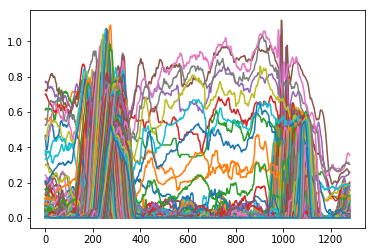

In [237]:
# Output visual display of the lane boundaries and numerical estimation of lane curvature 
# and vehicle position
video_output = 'project_video_output.mp4'
clip = VideoFileClip('project_video.mp4')
out_clip = clip.fl_image(pipeline)
%time out_clip.write_videofile(video_output, audio=False)